Read the csv using the path where it is located.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#If running locally

#df = pd.read_csv('./historical_data.csv')

In [3]:
# if running on your drive

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Python/6. Projects/1. Data Science/2. Doordash Delivery Prediction/historical_data.csv')

Mounted at /content/drive


In [4]:
df.head()

market_id           created_at actual_delivery_time  store_id  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:27:16      1845   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:56:29      5477   
2        3.0  2015-01-22 20:39:28  2015-01-22 21:09:09      5477   
3        3.0  2015-02-03 21:21:45  2015-02-03 22:13:00      5477   
4        3.0  2015-02-15 02:40:36  2015-02-15 03:20:26      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

In this link you will find the assignment:

https://platform.stratascratch.com/data-projects/delivery-duration-prediction

In [5]:
df.shape

(197428, 16)





Let's see the datatypes of each column.

In [6]:
df.dtypes

market_id                                       float64
created_at                                       object
actual_delivery_time                             object
store_id                                          int64
store_primary_category                           object
order_protocol                                  float64
total_items                                       int64
subtotal                                          int64
num_distinct_items                                int64
min_item_price                                    int64
max_item_price                                    int64
total_onshift_dashers                           float64
total_busy_dashers                              float64
total_outstanding_orders                        float64
estimated_order_place_duration                    int64
estimated_store_to_consumer_driving_duration    float64
dtype: object

created_at and actual_delivery_time should be in datetime type.

In [7]:
for col in ['created_at', 'actual_delivery_time']:
    df[col] = pd.to_datetime(df[col])

Let's see what columns has missing values.

In [8]:
df.isnull().sum()

market_id                                         987
created_at                                          0
actual_delivery_time                                7
store_id                                            0
store_primary_category                           4760
order_protocol                                    995
total_items                                         0
subtotal                                            0
num_distinct_items                                  0
min_item_price                                      0
max_item_price                                      0
total_onshift_dashers                           16262
total_busy_dashers                              16262
total_outstanding_orders                        16262
estimated_order_place_duration                      0
estimated_store_to_consumer_driving_duration      526
dtype: int64

First, let's drop the null values from the actual delivery time.

In [9]:
for col in ['market_id', 'actual_delivery_time', 'order_protocol', 'estimated_store_to_consumer_driving_duration']:
    df.dropna(subset=col, axis=0, inplace=True)

In [10]:
df['store_primary_category'] = df['store_primary_category'].fillna('Unknown')

I don't want to drop all 16k rows and I don't want to fill the missing values with the median because it will change the distribution of this features, a good way to recoup this missing values is using the InterativeImputer from scikit-learn to replace the missing values using properties of other features, so first let's visualize the distribution of these features.

TOTAL_ONSHIFT_DASHERS
------------------
37.0
44.8152820770239
0    0.0
Name: total_onshift_dashers, dtype: float64


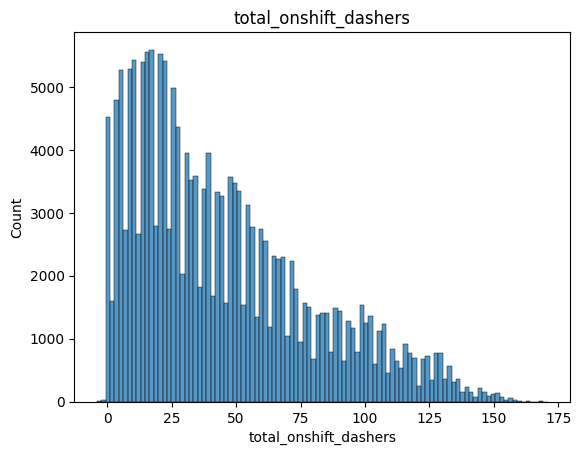

TOTAL_BUSY_DASHERS
------------------
34.0
41.75140968794445
0    0.0
Name: total_busy_dashers, dtype: float64


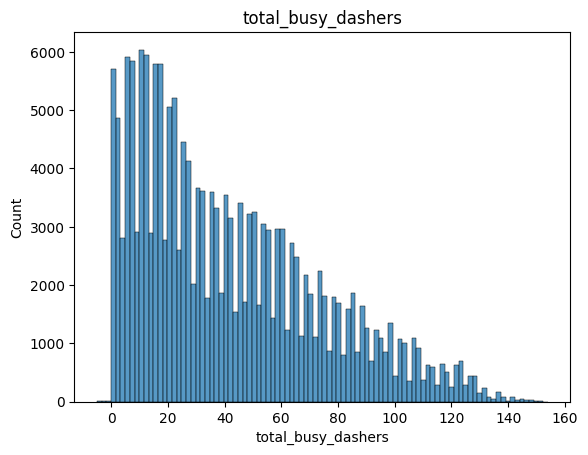

TOTAL_OUTSTANDING_ORDERS
------------------
41.0
58.06242226498229
0    0.0
Name: total_outstanding_orders, dtype: float64


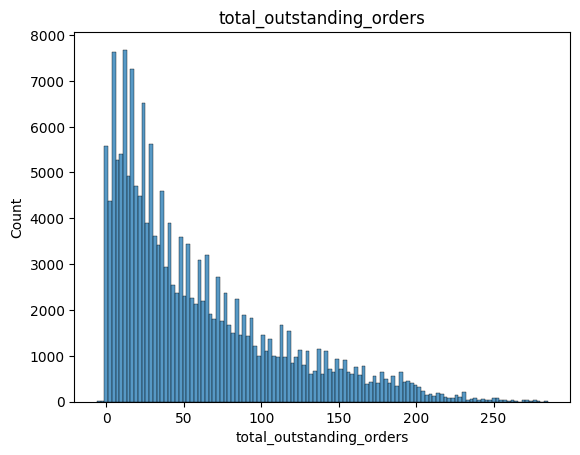

In [11]:
def display_distribution(dataframe, col):

    print(col.upper())
    print('------------------')
    print(dataframe[col].median())
    print(dataframe[col].mean())
    print(dataframe[col].mode())

    sns.histplot(dataframe[col])
    plt.title(col)
    plt.show()


for col in ['total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders']:
    display_distribution(df, col)

All these three variables doesn't have a normal distribution but if I replace the missing values with the median the distribution will completely change and other properties of this feature also, like the mode, so let's use the IterativeImputer.

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0)

cols_for_imputed_vals = df.select_dtypes(include=['number']).columns
cols_not_for_imputed_vals = df.select_dtypes(exclude=['number']).columns

imputed_df = pd.DataFrame(imputer.fit_transform(df[cols_for_imputed_vals]), columns=cols_for_imputed_vals)

After dividing the dataset into object and numeric I have to merge it all together and for that i used the merge function to merge by the index.

In [13]:
object_df = df[cols_not_for_imputed_vals].reset_index()
numeric_df = imputed_df.reset_index()

df = pd.merge(object_df, numeric_df, left_index=True, right_index=True)
df = df.drop(columns=['index_x', 'index_y'], axis=1)
df_imputed_copy = df.copy()

So I dropped the missing values from the columns that were a little portion from the total, but with the columns that had a bigger portion I imputed them, so now we have our dataset clean and ready. The next step is feature engineering and datapreprocesing. First let's start with feature engineering and see which columns could we add to the dataset that could potentially add value to the model.

In [14]:
display(df.isnull().sum())
display(df.shape)

created_at                                      0
actual_delivery_time                            0
store_primary_category                          0
market_id                                       0
store_id                                        0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
dtype: int64

(195402, 16)

So the first thing that we have to take in consideration is that when we create new features using existing ones, we have to be carefull and not include features that could cause data leakage, for example, in this case, if I create a new feature using the actual delivery time, it can give sensitive information to the training data and the model could actually know the answer while training. So the rule is that everytime you create new features is to ask yourself. At production, is this feature going to be available? When the model works with real data, I will know this feature? And if the answer is no, of course you shouldn't include it on your model.

Let's convert everything into minutes.

In [15]:
df_new = df_imputed_copy
df_new['target'] = (pd.to_datetime(df['actual_delivery_time']) - pd.to_datetime(df['created_at'])).dt.total_seconds() / 60
df_new.head()

created_at actual_delivery_time store_primary_category  market_id  \
0 2015-02-06 22:24:17  2015-02-06 23:27:16               american        1.0   
1 2015-02-10 21:49:25  2015-02-10 22:56:29                mexican        2.0   
2 2015-01-22 20:39:28  2015-01-22 21:09:09                Unknown        3.0   
3 2015-02-03 21:21:45  2015-02-03 22:13:00                Unknown        3.0   
4 2015-02-15 02:40:36  2015-02-15 03:20:26                Unknown        3.0   

   store_id  order_protocol  total_items  subtotal  num_distinct_items  \
0    1845.0             1.0          4.0    3441.0                 4.0   
1    5477.0             2.0          1.0    1900.0                 1.0   
2    5477.0             1.0          1.0    1900.0                 1.0   
3    5477.0             1.0          6.0    6900.0                 5.0   
4    5477.0             1.0          3.0    3900.0                 3.0   

   min_item_price  max_item_price  total_onshift_dashers  total_busy_dashers  \
0           557.0          1239.0                   33.0                14.0   
1          1400.0          1400.0                    1.0                 2.0   
2          1900.0          1900.0                    1.0                 0.0   
3           600.0          1800.0                    1.0                 1.0   
4          1100.0          1600.0                    6.0                 6.0   

   total_outstanding_orders  estimated_order_place_duration  \
0                      21.0                           446.0   
1                       2.0                           446.0   
2                       0.0                           446.0   
3                       2.0                           446.0   
4                       9.0                           446.0   

   estimated_store_to_consumer_driving_duration     target  
0                                         861.0  62.983333  
1                                         690.0  67.066667  
2                                         690.0  29.683333  
3                                         289.0  51.250000  
4                                         650.0  39.833333

Now let's see how the target variable is distributed.

<Axes: xlabel='target', ylabel='Count'>

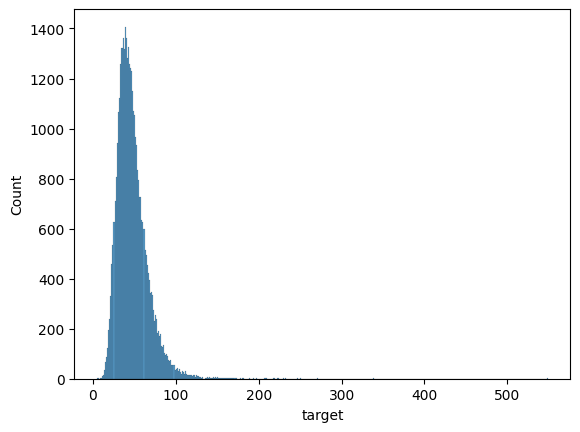

In [16]:
sns.histplot(df_new['target'].sample(40000))

<Axes: ylabel='target'>

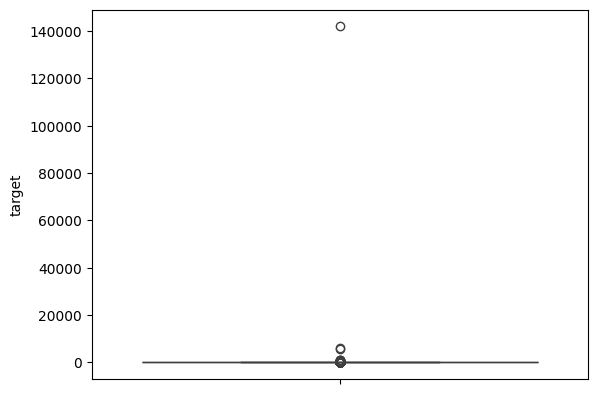

In [17]:
sns.boxplot(df_new['target'])

As you can see, there could be outliers that may cause the algorithm make mistakes because they are unrealistic, for example look at that outlier of 140 thousand minutes for a delivery, of course that is not true, so let's stablish realistic times for deliveries, this can be calculated using Quartiles.

In [18]:
# This formula will calculate the range in which the data can be and all out of
# those values can be considered an outlier.

def calculate_IQR_limits(data):

    P_25 = data.quantile(q=0.25)
    P_75 = data.quantile(q=0.75)
    IQR = P_75 - P_25

    # Calculate the lower and upper limits for outliers
    lower_limit = P_25 - 1.5 * IQR
    upper_limit = P_75 + 1.5 * IQR

    return lower_limit, upper_limit

def drop_outliers(df, col, Inf_limit, Sup_limit):
    df = df[(df[col] >= Inf_limit) & (df[col] <= Sup_limit)]
    return df


Inferior_limit, Superior_limit = calculate_IQR_limits(df_new['target'])

print(f"Inferior Limit: {Inferior_limit}")
print(f"Superior Limit: {Superior_limit}")

# Select values that are outside the calculated limits (potential outliers)
outliers = df_new[(df_new['target'] < Inferior_limit) | (df_new['target'] > Superior_limit)]

print(f"Number of outliers finded: {len(outliers)}")

df_new = drop_outliers(df_new, 'target', Inferior_limit, Superior_limit)

Inferior Limit: 3.1583333333333385
Superior Limit: 88.29166666666666
Number of outliers finded: 6218


Now let's see the distribution again just to check.

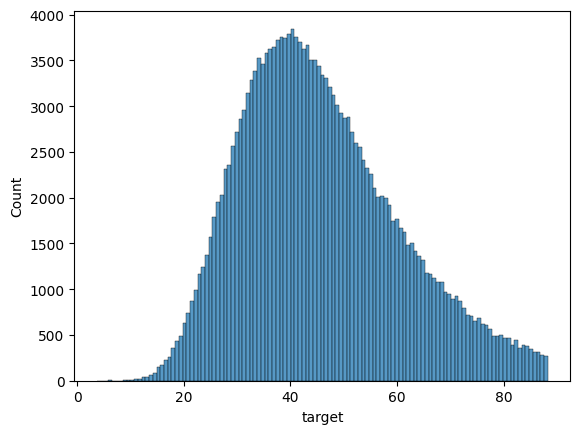

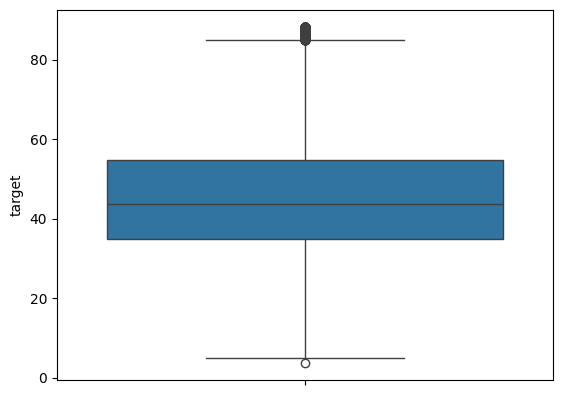

In [19]:
sns.histplot(df_new['target'])
plt.show()
sns.boxplot(df_new['target'])
plt.show()

It is way better, the distribution is not normal but is a lot better and the boxplot tells us that there are outliers but not a monstruous difference like before, so the next thing is choosing our inputs again, and watching closely every input because if one feature has crazy outliers that could make our model a lot worse, so let's do it. So first let's convert columns of money in dollars and columns of time in minutes.

In [20]:
import warnings

warnings.filterwarnings('ignore')

# From cents to dollars

for col in ['subtotal', 'min_item_price', 'max_item_price']:
    df_new[col] = df_new[col] / 100

# From seconds to minutes

for col in ['estimated_order_place_duration', 'estimated_store_to_consumer_driving_duration']:
    df_new[col] = df_new[col] / 60

Now first let's go column by column and evaluate them in terms of outliers and how clean the data is, and then let's analyze each column to see it's distribution.

Let's examine the continuous columns and see if they have outliers.

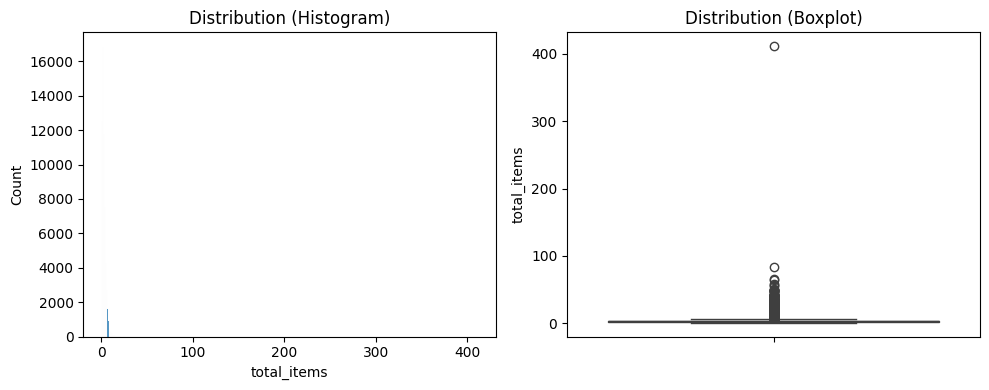

In [21]:
def hist_boxplot(data, sample):


    fig, ax = plt.subplots(1, 2, figsize=(10, 4))

    sns.histplot(data.sample(sample), ax=ax[0])
    ax[0].set_title('Distribution (Histogram)')
    ax[0].set_xlabel(data.name)
    ax[0].set_ylabel('Count')

    sns.boxplot(data, ax=ax[1])
    ax[1].set_title('Distribution (Boxplot)')
    ax[1].set_ylabel(data.name)

    plt.tight_layout()
    plt.show()

hist_boxplot(df_new['total_items'], 60000)

So I am thinking about something that is pretty interesting, probably every column has outliers, and this outliers need to be dropped, so if I just grab all the columns and drop its outliers that could end up with losing data for other columns that may be good for the model, so let's pick first the columns and then drop the values.

In [22]:
df_new['store_primary_category'].unique()

array(['american', 'mexican', 'Unknown', 'indian', 'italian', 'sandwich',
       'thai', 'cafe', 'salad', 'pizza', 'chinese', 'singaporean',
       'burger', 'breakfast', 'mediterranean', 'japanese', 'greek',
       'catering', 'filipino', 'convenience-store', 'other', 'korean',
       'vegan', 'asian', 'barbecue', 'fast', 'dessert', 'smoothie',
       'seafood', 'vietnamese', 'cajun', 'steak', 'middle-eastern',
       'soup', 'vegetarian', 'persian', 'nepalese', 'sushi',
       'latin-american', 'hawaiian', 'chocolate', 'burmese', 'british',
       'pasta', 'alcohol', 'dim-sum', 'peruvian', 'turkish', 'malaysian',
       'ethiopian', 'afghan', 'bubble-tea', 'german', 'french',
       'caribbean', 'gluten-free', 'comfort-food', 'gastropub',
       'pakistani', 'moroccan', 'spanish', 'southern', 'tapas', 'russian',
       'brazilian', 'european', 'cheese', 'african', 'argentine',
       'kosher', 'irish', 'lebanese', 'belgian', 'indonesian',
       'alcohol-plus-food'], dtype=object)

In [23]:
df_new['market_id'].unique()

array([1., 2., 3., 4., 5., 6.])

In [24]:
df_new['order_protocol'].unique()

array([1., 2., 3., 4., 5., 6., 7.])

Before analyzing the continuous features, let's do some feature engineering. but not by doing operations between input features because that may cuase multicollinearity, it is better just to extract insight like day of the week from the order and stuff like that.

In [25]:
df_new['hour_of_day'] = df_new['created_at'].astype(str).str.split(' ').str[1].str[0:2].astype(int)
df_new['day_of_week'] = df_new['created_at'].dt.dayofweek
df_new['weekend'] = (df_new['day_of_week'] > 5).astype(int)

Cool, now we can just drop the outliers for each column, let's use the complete dataset so when trying another model it is already clean and without outliers in those columns.

In [26]:
print(f'Before dropping linear cols outliers: {df_new.shape[0]} rows')

for col in df_new.select_dtypes('number').columns:
    Lower_Limit, Upper_Limit = calculate_IQR_limits(df_new[col])
    df_new = drop_outliers(df_new, col, Lower_Limit, Upper_Limit)

print(f'After dropping linear cols outliers: {df_new.shape[0]} rows')

Before dropping linear cols outliers: 189184 rows
After dropping linear cols outliers: 125237 rows


Fine, now it's time for feature engineering. Something I want to do first is drop the rows from orders and dashers if it is negative

In [27]:
print(f'Before droping outliers: {df_new.shape[0]} rows')

for col in df_new.select_dtypes('number').columns:
    Low, Up = calculate_IQR_limits(df_new[col])
    df_new = drop_outliers(df_new, col, Low, Up)

print(f'After droping outliers: {df_new.shape[0]} rows')

Before droping outliers: 125237 rows
After droping outliers: 117087 rows


In [28]:
print(f'Before droping negative values: {df_new.shape[0]} rows')

cols_without_neg = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
                    'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'estimated_order_place_duration',
                    'estimated_store_to_consumer_driving_duration', 'target']

for col in cols_without_neg:
    df_new = df_new[df_new[col] >= 0]

print(f'After dropping negative values: {df_new.shape[0]} rows')

Before droping negative values: 117087 rows
After dropping negative values: 117028 rows


Also something that concerns me is that there could never be more busy dashers than onshift dashers, that is not possible so let's drop the rows that fit that criteria.

In [29]:
print(f'Before dropping busy and onshift dashers: {df_new.shape[0]} rows')

df_new = df_new[~(df_new['total_busy_dashers'] > df_new['total_onshift_dashers'])]

print(f'After dropping busy and onshift dashers: {df_new.shape[0]} rows')

Before dropping busy and onshift dashers: 117028 rows
After dropping busy and onshift dashers: 94600 rows


It is also not possible to have more busy dashers than outstanding orders.

In [30]:
print(f'Before dropping busy dashers and outstanding orders: {df_new.shape[0]} rows')

df_new = df_new[~(df_new['total_busy_dashers'] > df_new['total_outstanding_orders'])]

print(f'After dropping busy dashers and outstanding orders: {df_new.shape[0]} rows')

Before dropping busy dashers and outstanding orders: 94600 rows
After dropping busy dashers and outstanding orders: 85341 rows


Now there should not be a row that has a min item price or a max item price higher than the subtotal, because it's basically impossible.

In [31]:
print(f'Before dropping subtotal and min and max item price: {df_new.shape[0]} rows')

df_new = df_new[~(df_new['subtotal'] < df_new['max_item_price'])]
df_new = df_new[~(df_new['subtotal'] < df_new['min_item_price'])]

print(f'After dropping subtotal and min and max item price: {df_new.shape[0]} rows')

Before dropping subtotal and min and max item price: 85341 rows
After dropping subtotal and min and max item price: 85117 rows


It is also not possible to have a row in which the number of distinct items is greater than the total items

In [32]:
df_new[(df_new['num_distinct_items'] > df_new['total_items'])]

Empty DataFrame
Columns: [created_at, actual_delivery_time, store_primary_category, market_id, store_id, order_protocol, total_items, subtotal, num_distinct_items, min_item_price, max_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_order_place_duration, estimated_store_to_consumer_driving_duration, target, hour_of_day, day_of_week, weekend]
Index: []

Perfect, there isn't, now here the logic is a little bit harder, there can't be a row that has a max price that is the same as the subtotal and the total items is bigger than one.

In [33]:
df_new = df_new[~((df_new['subtotal'] == df_new['max_item_price']) & (df_new['total_items'] > 1))]
df_new = df_new[~((df_new['subtotal'] == df_new['min_item_price']) & (df_new['total_items'] > 1))]

Now that there are no crazy samples that could kill our model. Let's finally do some feature engineering, it is as simple as creating new columns based on the ones we already have, but being carefull that you don't leake any data from the target because the model will be able to predict with a 100% accuracy.

In [34]:
# 1. Let's start by creating the columns related to orders and dashers availability.

df_new['available_dashers'] = df_new['total_onshift_dashers'] - df_new['total_busy_dashers']

df_new['utilized_dashers'] = (df_new['total_busy_dashers'] / df_new['total_onshift_dashers']).replace(np.inf, 0)
df_new = df_new.dropna(subset=['available_dashers', 'utilized_dashers'], axis=0)

df_new['total_non_taken_orders'] = df_new['total_outstanding_orders'] - df_new['total_busy_dashers']

df_new['orders_to_available_dashers'] = (df_new['total_non_taken_orders'] / df_new['available_dashers']).replace(np.inf, 0)
df_new = df_new.dropna(subset=['orders_to_available_dashers'], axis=0)

# 2. Now let's go with item features, let's create 2 new features calculating the average price
# item pero order and the variety of each order

df_new['avg_price_item'] = (df_new['subtotal'] / df_new['total_items']).replace(np.inf, 0)

df_new['item_variety'] = df_new['num_distinct_items'] / df_new['total_items'].replace(np.inf, 0)

In [35]:
df_new.shape[0]

80852

Perfect, now it's time to convert the string type column into numeric but we have too decide how we want to do it, being honest, doing a one hot encoding doesn't seem like a good option because the dataframe dimensionality will grow too much. A better idea could be using the frequency of each class or each option as the value and that is what we are going to do, but careful, because this feature has a lot of values that appear 5 times or less, for that, we are going to group them into a new category that will be 'Other'. The rule will be, if the count of the category is below represents less than the 0.5% of the dataset, that category will be added into the Others category.

In [36]:
threshold = df_new.shape[0] * 0.005

store_map = {}
store_value_counts = df_new['store_primary_category'].value_counts().reset_index()

for name, value in zip(store_value_counts['store_primary_category'], store_value_counts['count']):
    store_map[name] = value


def replace_store_category(name):
    if name in store_map and store_map[name] < threshold:
        return 'Other'
    else:
        return name

# Apply the function to the column in df_new

df_new['store_primary_category'] = df_new['store_primary_category'].apply(replace_store_category)


# Now let's create the count feature based on the modified categories

store_category_counts = df_new['store_primary_category'].value_counts()
df_new['store_primary_category_counts'] = df_new['store_primary_category'].map(store_category_counts)

display(df_new[['store_primary_category', 'store_primary_category_counts']].head())

store_primary_category  store_primary_category_counts
0                american                           7824
8                  indian                           3188
19                mexican                           7516
28                italian                           2207
31               sandwich                           5043

The other columns that are categorical (order protocol and market id), doesn't have a high cardinality, so the dataframe won't grow too much in terms of dimensionality. It is said that features that have 10 unique categories or less are considered low cardinality features and we can use one-hot encoding, so for these two features I will do that.

In [37]:
one_hot_market_id  = pd.get_dummies(df_new['market_id'], prefix='market_id').astype(int)
one_hot_order_protocol = pd.get_dummies(df_new['order_protocol'], prefix='order_protocol').astype(int)

df_new = pd.concat([df_new, one_hot_market_id, one_hot_order_protocol], axis=1)
df_new.head()

created_at actual_delivery_time store_primary_category  market_id  \
0  2015-02-06 22:24:17  2015-02-06 23:27:16               american        1.0   
8  2015-02-16 00:11:35  2015-02-16 00:38:01                 indian        2.0   
19 2015-01-31 02:21:23  2015-01-31 03:11:42                mexican        1.0   
28 2015-01-26 02:09:48  2015-01-26 02:47:22                italian        1.0   
31 2015-01-30 19:49:30  2015-01-30 20:28:45               sandwich        3.0   

    store_id  order_protocol  total_items  subtotal  num_distinct_items  \
0     1845.0             1.0          4.0     34.41                 4.0   
8     5477.0             3.0          4.0     47.71                 3.0   
19    4139.0             1.0          2.0      9.50                 2.0   
28    5058.0             1.0          3.0     38.00                 3.0   
31    4149.0             2.0          4.0     34.90                 3.0   

    min_item_price  ...  market_id_4.0  market_id_5.0  market_id_6.0  \
0             5.57  ...              0              0              0   
8             8.20  ...              0              0              0   
19            1.50  ...              0              0              0   
28            8.00  ...              0              0              0   
31            1.75  ...              0              0              0   

    order_protocol_1.0  order_protocol_2.0  order_protocol_3.0  \
0                    1                   0                   0   
8                    0                   0                   1   
19                   1                   0                   0   
28                   1                   0                   0   
31                   0                   1                   0   

    order_protocol_4.0  order_protocol_5.0  order_protocol_6.0  \
0                    0                   0                   0   
8                    0                   0                   0   
19                   0                   0                   0   
28                   0                   0                   0   
31                   0                   0                   0   

    order_protocol_7.0  
0                    0  
8                    0  
19                   0  
28                   0  
31                   0  

[5 rows x 40 columns]

In [38]:
df_new = df_new.reset_index()

Now for the Linear Regression we need to know which features have the highest correlation with the target feature.

In [39]:
corr_df = df_new.corr(numeric_only=True)['target'].sort_values(ascending=False)[1:]
corr_df

estimated_store_to_consumer_driving_duration    0.274063
total_non_taken_orders                          0.232835
utilized_dashers                                0.188205
subtotal                                        0.181217
orders_to_available_dashers                     0.150038
total_outstanding_orders                        0.139950
num_distinct_items                              0.126416
total_items                                     0.118596
max_item_price                                  0.115919
estimated_order_place_duration                  0.103554
order_protocol_1.0                              0.089998
total_busy_dashers                              0.069582
market_id_1.0                                   0.068852
avg_price_item                                  0.057991
order_protocol_6.0                              0.031003
total_onshift_dashers                           0.030720
market_id_3.0                                   0.019867
market_id_5.0                                   0.011159
market_id_6.0                                   0.006621
store_primary_category_counts                   0.002814
order_protocol_4.0                              0.000659
order_protocol_2.0                             -0.000017
store_id                                       -0.002026
order_protocol_7.0                             -0.003384
min_item_price                                 -0.004065
index                                          -0.005144
day_of_week                                    -0.015368
market_id                                      -0.015411
item_variety                                   -0.016151
order_protocol_3.0                             -0.021448
market_id_4.0                                  -0.029975
market_id_2.0                                  -0.055996
order_protocol_5.0                             -0.078771
order_protocol                                 -0.094067
available_dashers                              -0.118306
hour_of_day                                    -0.153434
weekend                                              NaN
Name: target, dtype: float64

Perfect, I don't want to lose time in my model and as we are starting with a multiple linear Regression, I will just choose the features that have the highest correlation with the target but I have to be carefull and not choose input features that are correlated with each other, for example total_onshift_dashers may be correlated to total_busy_dashers, but this doesn't mean I have to drop one of them, I can use algorithms like PCA to merge the two into 1 variable. For the input features I will establish a threshold of at least 0.11 or -0.11 correlation for it to be included, anything lower than that will not be considered, but I prefer selecting each variable manually because I know which ones could cause multicolinearity since there is a lot of them created on the feature engineering section.

--------------------------------------------------estimated_store_to_consumer_driving_duration-------------------------------------------------------



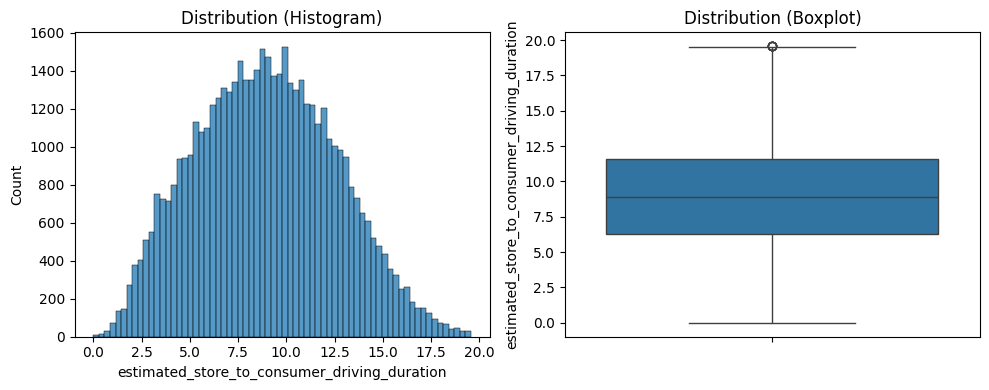



--------------------------------------------------total_non_taken_orders-------------------------------------------------------



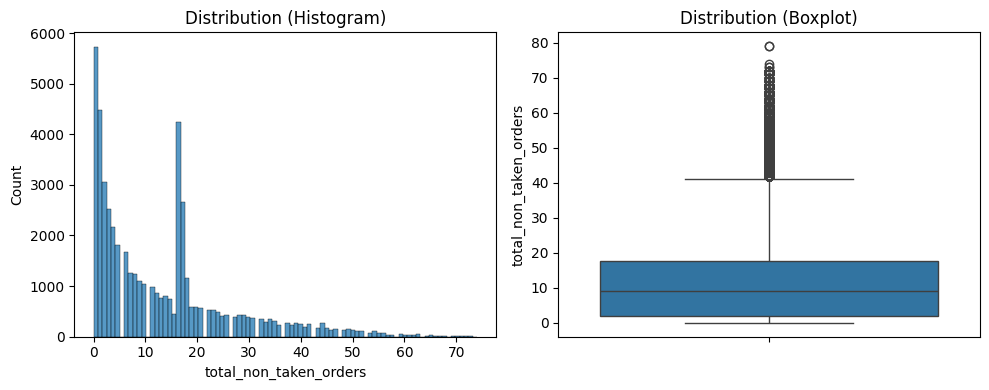



--------------------------------------------------utilized_dashers-------------------------------------------------------



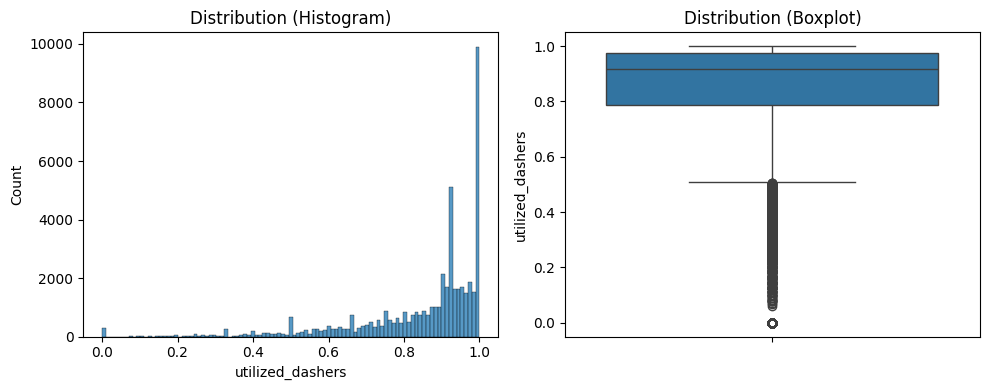



--------------------------------------------------subtotal-------------------------------------------------------



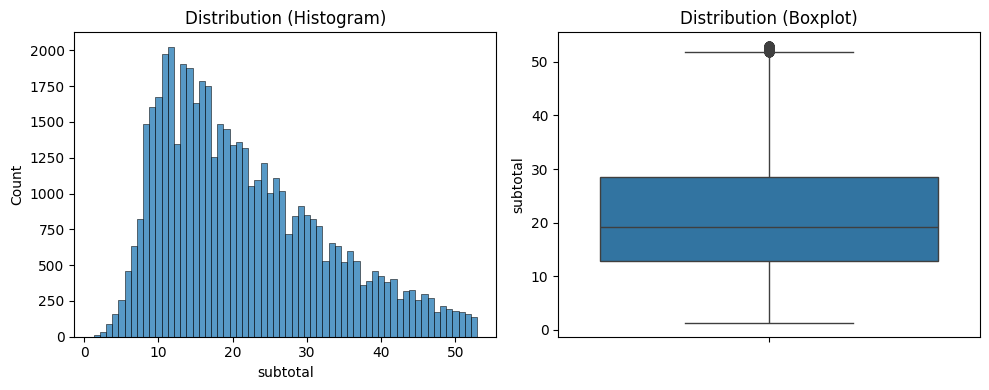



--------------------------------------------------orders_to_available_dashers-------------------------------------------------------



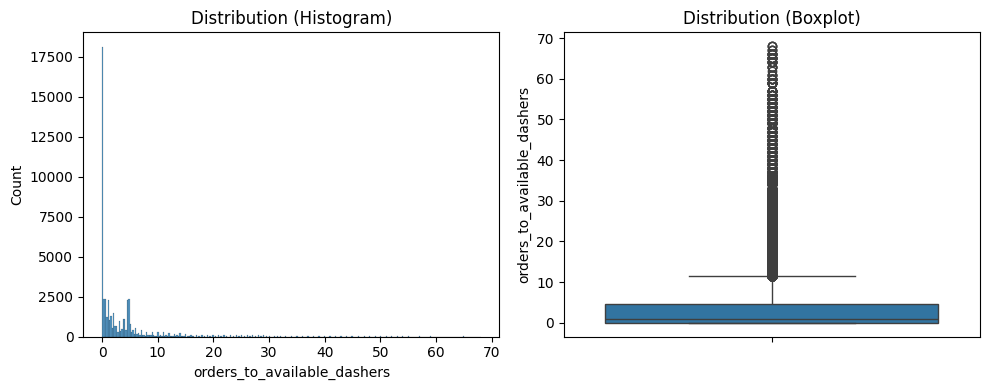



--------------------------------------------------total_outstanding_orders-------------------------------------------------------



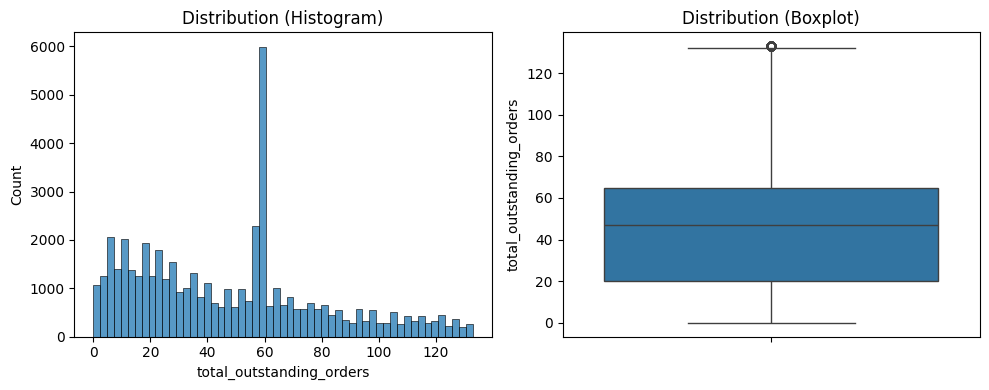



--------------------------------------------------num_distinct_items-------------------------------------------------------



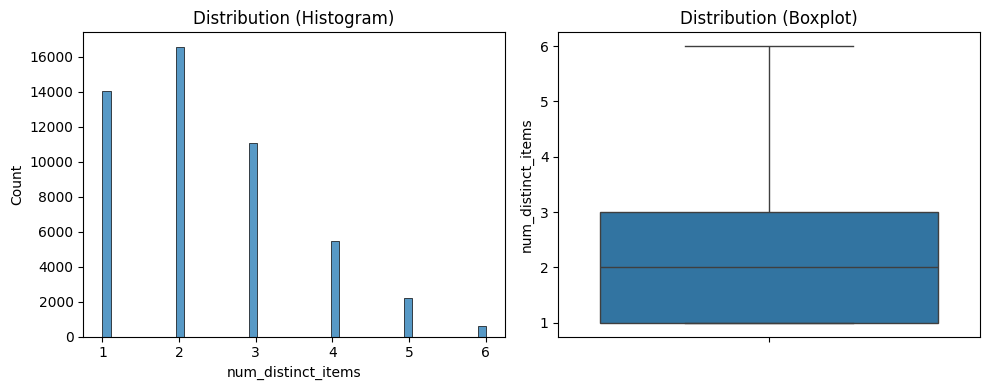



--------------------------------------------------total_items-------------------------------------------------------



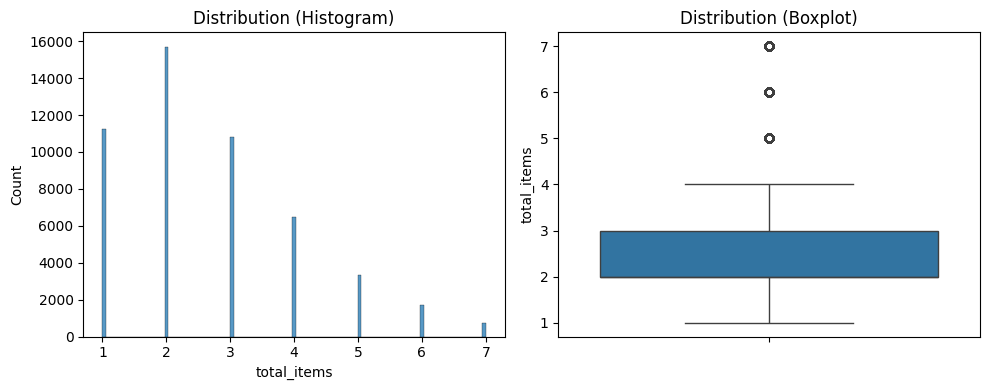



--------------------------------------------------max_item_price-------------------------------------------------------



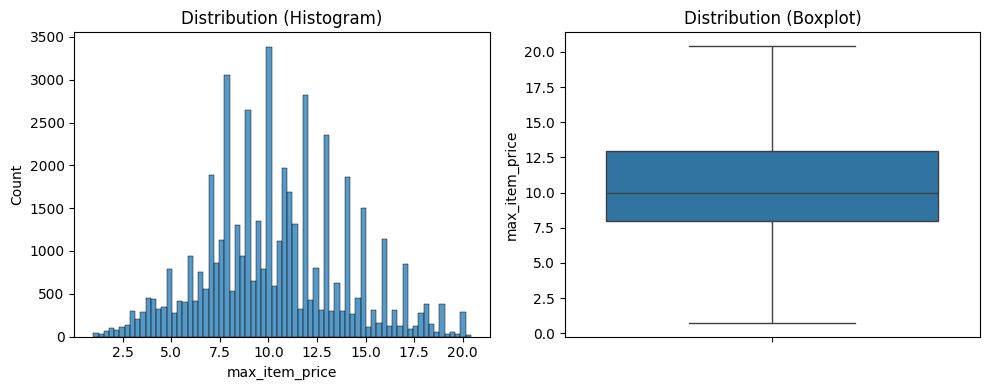



--------------------------------------------------available_dashers-------------------------------------------------------



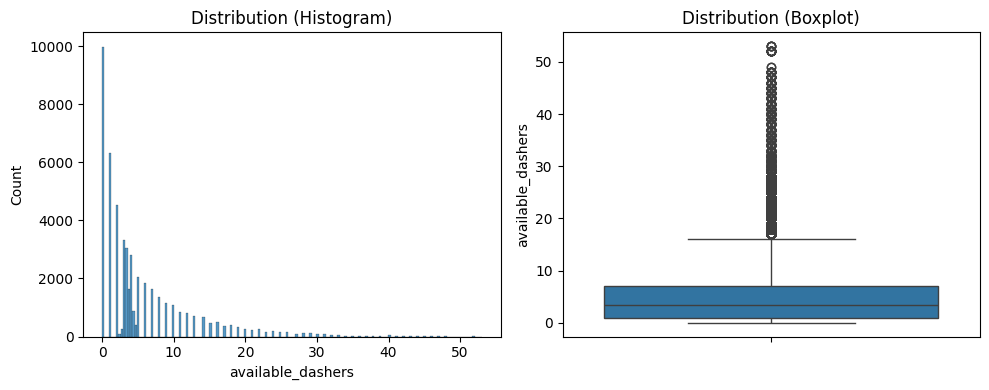



--------------------------------------------------hour_of_day-------------------------------------------------------



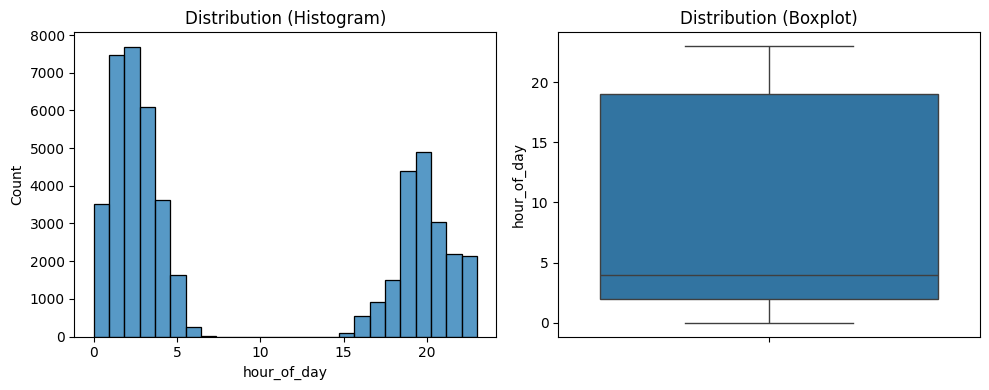

In [40]:
cols_for_model = []

for name, val in zip(corr_df.index, corr_df):
    if abs(val) > 0.11:
        cols_for_model.append(name)

# Now let's look the distribution of these features.

for col in cols_for_model:
    print(f'--------------------------------------------------{col}-------------------------------------------------------\n')
    hist_boxplot(df_new[col], 50000)
    print('\n')

<Axes: >

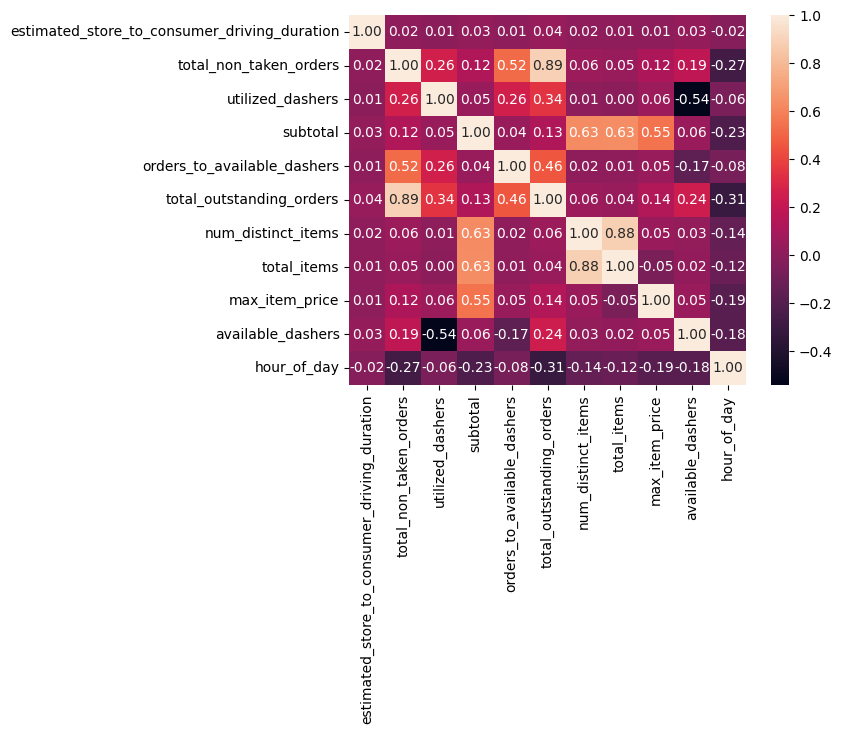

In [41]:
sns.heatmap(df_new[cols_for_model].corr(), annot=True, fmt='.2f')

So looking at the heatmap, there are three variables that are correlated that is subtotal with num_distinct_items and also  subtotal with max_item_price, this doesn't mean anything until now, let's check the VIF, if the VIF is above 5 it means we should probably do something with these two features.

In [42]:
df_new.isnull().sum()

index                                           0
created_at                                      0
actual_delivery_time                            0
store_primary_category                          0
market_id                                       0
store_id                                        0
order_protocol                                  0
total_items                                     0
subtotal                                        0
num_distinct_items                              0
min_item_price                                  0
max_item_price                                  0
total_onshift_dashers                           0
total_busy_dashers                              0
total_outstanding_orders                        0
estimated_order_place_duration                  0
estimated_store_to_consumer_driving_duration    0
target                                          0
hour_of_day                                     0
day_of_week                                     0
weekend                                         0
available_dashers                               0
utilized_dashers                                0
total_non_taken_orders                          0
orders_to_available_dashers                     0
avg_price_item                                  0
item_variety                                    0
store_primary_category_counts                   0
market_id_1.0                                   0
market_id_2.0                                   0
market_id_3.0                                   0
market_id_4.0                                   0
market_id_5.0                                   0
market_id_6.0                                   0
order_protocol_1.0                              0
order_protocol_2.0                              0
order_protocol_3.0                              0
order_protocol_4.0                              0
order_protocol_5.0                              0
order_protocol_6.0                              0
order_protocol_7.0                              0
dtype: int64

Perfect, now we have the columns we want and the dataset cleared of outliers (just for the columns used on the linear regression), so now let's see if there is any correlation between the inputs and also let's use the VIF to check multicollinearity.

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_VIF(data):

    VIF = pd.DataFrame()
    VIF['features'] = data.columns
    VIF['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return VIF

VIF = calculate_VIF(df_new[cols_for_model])
VIF

features        VIF
0   estimated_store_to_consumer_driving_duration   6.640655
1                         total_non_taken_orders  10.306969
2                               utilized_dashers  21.270703
3                                       subtotal  17.931778
4                    orders_to_available_dashers   1.967178
5                       total_outstanding_orders  18.365218
6                             num_distinct_items  23.301000
7                                    total_items  26.470280
8                                 max_item_price  18.466562
9                              available_dashers   2.413395
10                                   hour_of_day   2.252981

So for the interpretability of the model is not a good idea to use PCA because there is no way to interpret it, so let's just drop the features that are highly correlated and keep the one that has the strongest correlation with the target that in this case is subtotal and num_distinct_items.

In [44]:
cols_for_model_copy = cols_for_model.copy()
cols_to_drop_lin = ['num_distinct_items', 'total_items', 'total_outstanding_orders', 'available_dashers', 'max_item_price', 'utilized_dashers']

for col in cols_to_drop_lin:
    cols_for_model.remove(col)

VIF = calculate_VIF(df_new[cols_for_model])
VIF

features       VIF
0  estimated_store_to_consumer_driving_duration  4.221573
1                        total_non_taken_orders  2.736446
2                                      subtotal  3.547483
3                   orders_to_available_dashers  1.774697
4                                   hour_of_day  1.826976

Before developing the model, I would like to see an scatter plot of every feature with the target to see the relation.

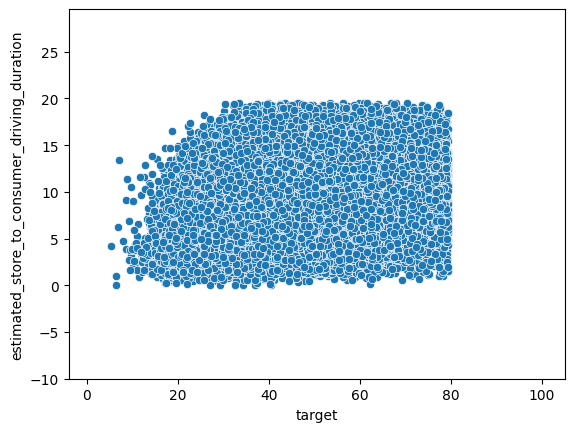

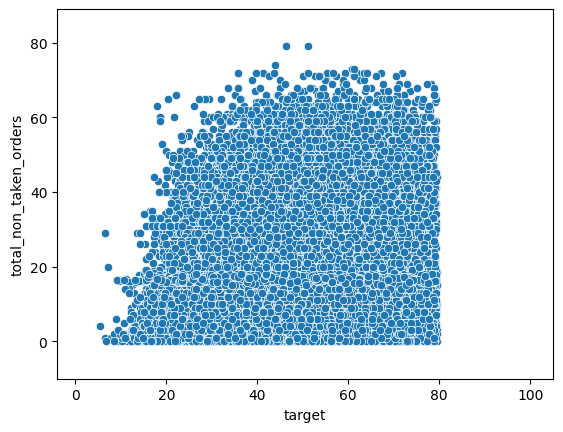

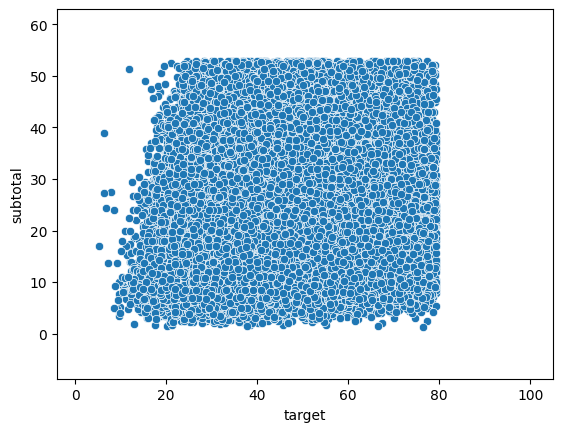

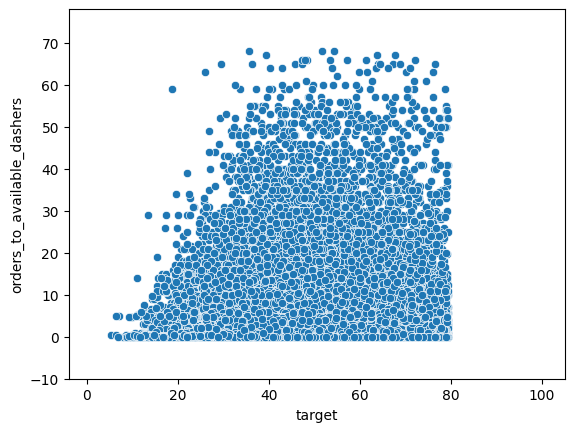

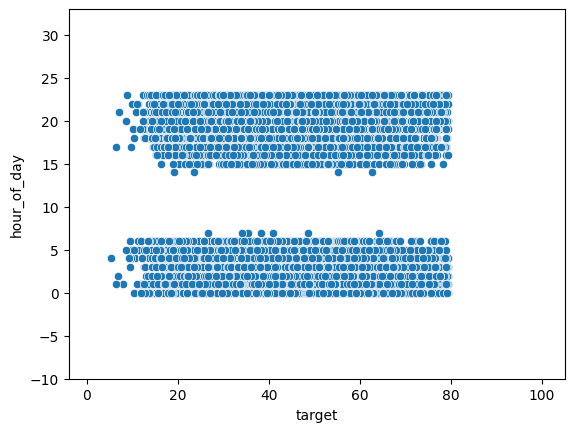

In [45]:
for col in cols_for_model:
  #  plt.figure(figsize=(15, 15))
    sns.scatterplot(data=df_new, x='target', y=col)
    plt.ylim(df_new[col].min() - 10, df_new[col].max() + 10)
    plt.xlim(-4, 105)

    plt.show()

Now, remember that training a model requires a human-based level performance, so knowing the error a person usually makes while predicting the time his order will be delivered is key. For this example, I don't have information about real world statistics, but according to ChatGPT, a person usually tries to predict the time of a delivery using information like the type of food (fast food like McDonalds or Sushi), the distance between the restaurant and the place the person is, the time of the week and day the order was created, while ML algorithms usually focus on the availability of delivery guys and the amount of orders for that specific moment. The error margin of users while estimating the time the order will take is around 10 to 30 minutes, so that is our human-based level performance, our model should be able to be in that range.

Let's create all the functions to divide the training, validation and testing data and train the models.

Before training all the models, understand that the way the model is measuring the error is in terms of minutes, sometimes the minutes could be 8.70 and not 8.60 because it is representing it as a percentage of minutes, for example 8.70 minutes is 8 minutes and 0.70 * 60 = 42 seconds.

In [46]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error
import io
import contextlib

In [47]:
# Function to divide data and scale them.

def transform_features(data:pd.DataFrame, target:str, scaler_choosen:str, continuous:list, categorical=None, transform_y=False):

    y = data[target]

    if categorical:
        X = data[continuous + categorical]
    else:
        X = data[continuous]

    X_train, X_sample, y_train, y_sample = train_test_split(X, y, test_size=0.5, random_state=1)
    X_cv, X_test, y_cv, y_test = train_test_split(X_sample, y_sample, test_size=0.5, random_state=1)

    del X_sample, y_sample

    train_indexes = X_train.index
    cv_indexes = X_cv.index
    test_indexes = X_test.index

    X_train_continuous = X_train[continuous]
    X_cv_continuous = X_cv[continuous]
    X_test_continuous = X_test[continuous]

    match scaler_choosen.lower():

        case 'standard':
            S_scaler = StandardScaler()
            X_train_continuous = pd.DataFrame(S_scaler.fit_transform(X_train_continuous), columns=continuous, index=train_indexes)
            X_cv_continuous = pd.DataFrame(S_scaler.transform(X_cv_continuous), columns=continuous, index=cv_indexes)
            X_test_continuous = pd.DataFrame(S_scaler.transform(X_test_continuous), columns=continuous, index=test_indexes)
        case 'minmax':
            MM_scaler = MinMaxScaler()
            X_train_continuous = pd.DataFrame(MM_scaler.fit_transform(X_train_continuous), columns=continuous, index=train_indexes)
            X_cv_continuous = pd.DataFrame(MM_scaler.transform(X_cv_continuous), columns=continuous, index=cv_indexes)
            X_test_continuous = pd.DataFrame(MM_scaler.transform(X_test_continuous), columns=continuous, index=test_indexes)
        case _:
            return 'Choose a valid scaler (minmax, standard, log or logdiff)'

    if transform_y:
        y_train_log = np.log1p(y_train)
        y_cv_log = np.log1p(y_cv)
        y_test_log = np.log1p(y_test)

        return X_train, X_test, y_train_log, y_test_log, y_test

    if categorical:
        X_train_categorical = X_train[categorical]
        X_cv_categorical = X_cv[categorical]
        X_test_categorical = X_test[categorical]
        X_train = pd.concat([X_train_continuous, X_train_categorical], axis=1)
        X_cv = pd.concat([X_cv_continuous, X_cv_categorical], axis=1)
        X_test = pd.concat([X_test_continuous, X_test_categorical], axis=1)

        return X_train, y_train, X_cv, y_cv, X_test, y_test

    return X_train_continuous, y_train, X_cv_continuous, y_cv, X_test_continuous, y_test

In [48]:
# Function to train and get the linear models results

def train_linear_model(X_train, y_train, X_cv, y_cv, X_test, y_test, model: str, poly:bool, lambda_=1.0, poly_features=2, gridsearch=False):

    if poly:
        poly_f = PolynomialFeatures(degree=poly_features)

        X_train = poly_f.fit_transform(X_train)
        X_cv = poly_f.transform(X_cv)
        X_test = poly_f.transform(X_test)

        print(f'--------------------- Model with {poly_features} polynomial order ----------------------\n')


    if model.lower() == 'linear':
        model_s = LinearRegression()
        print('--------------------------- Linear Model -------------------------------\n')

    elif model.lower() == 'lasso':
        model_s = Lasso(alpha=lambda_)
        print('--------------------------- Lasso Model --------------------------------\n')

    elif model.lower() == 'ridge':
        model_s = Ridge(alpha=lambda_)
        print('--------------------------- Ridge Model --------------------------------\n')
    else:
        return 'Select between Linear, Lasso or Ridge.'


    model_s.fit(X_train, y_train)

    y_pred_train = model_s.predict(X_train)
    y_pred_cv = model_s.predict(X_cv)
    y_pred_test = model_s.predict(X_test)

    train_residuals = y_train - y_pred_train
    cv_residuals = y_cv - y_pred_cv
    test_residuals = y_test - y_pred_test

    # The P90 of residuals will tell us by how much the 10% of predictions are making mistakes
    # this is useful for getting to know by how much minutes are the big errors the model is making.

    print('Train_results\n')
    train_r2 = r2_score(y_train, y_pred_train)
    train_mae = mean_absolute_error(y_train, y_pred_train)
    train_rmse = root_mean_squared_error(y_train, y_pred_train)
    train_p90 = np.percentile(abs(train_residuals), 90)
    print(f'r2: {round(train_r2, 2)}\n')
    print(f'MAE: {round(train_mae, 2)}\n')
    print(f'RMSE: {round(train_rmse, 2)}\n')
    print(f'P90: {round(train_p90, 2)}\n\n')

    print('CV results\n')
    cv_r2 = r2_score(y_cv, y_pred_cv)
    cv_mae = mean_absolute_error(y_cv, y_pred_cv)
    cv_rmse = root_mean_squared_error(y_cv, y_pred_cv)
    cv_p90 = np.percentile(abs(cv_residuals), 90)
    print(f'r2: {round(cv_r2, 2)}\n')
    print(f'MAE: {round(cv_mae, 2)}\n')
    print(f'RMSE: {round(cv_rmse, 2)}\n')
    print(f'P90: {round(cv_p90, 2)}\n\n')

    print('test results\n')
    test_r2 = r2_score(y_test, y_pred_test)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_rmse = root_mean_squared_error(y_test, y_pred_test)
    test_p90 = np.percentile(abs(test_residuals), 90)
    print(f'r2: {round(test_r2, 2)}\n')
    print(f'MAE: {round(test_mae, 2)}\n')
    print(f'RMSE: {round(test_rmse, 2)}\n')
    print(f'P90: {round(test_p90, 2)}')

    return y_test, y_pred_test, test_residuals, train_rmse, cv_rmse, test_rmse

In [49]:
# Function to iterate until finding the best model.

def find_best_lin_model(X_train, y_train, X_cv, y_cv, X_test, y_test, model, poly_degree, lambda_=[0.01, 0.1, 1, 10, 100, 1000]):

    # Let's build a function that replicates a Grid Search and plot a comparison between the performance
    # of the model in terms of RMSE and the degrees, for this case I will not use Lasso for interpretability.

    if model.lower() not in ['linear', 'ridge']:
        return 'Invalid model'

    training_rmses = []
    cv_rmses = []
    testing_rmses = []

    results = {}
    optimal_degree = 0
    optimal_lambda = 0

    best_score = float('inf')

    print(f'Performance on the {model} model\n')

    if model.lower() == 'linear':

        try:

            for deg in poly_degree:
                # This is to avoid all the prints from the training function
                with contextlib.redirect_stdout(io.StringIO()):
                    y_test, y_pred, residuals, train_rmse, cv_rmse, test_rmse = train_linear_model(X_train, y_train, X_cv, y_cv, X_test, y_test, model=model, \
                                                                                                    poly=True, lambda_=0, poly_features=deg)

                training_rmses.append(train_rmse)
                cv_rmses.append(cv_rmse)
                testing_rmses.append(test_rmse)

                if test_rmse < best_score:
                    best_score = test_rmse
                    optimal_degree = deg
                    results['scoring'] = {'RMSE': test_rmse, 'optimal_degree':optimal_degree}
                    results['predictions'] = {'y_test': y_test, 'y_pred': y_pred, 'residuals': residuals}

            plot_comparison(list(poly_degree), training_rmses, cv_rmses, testing_score=testing_rmses, x_axis='degree')

        except Exception as e:
            print(e)
            return


    if model.lower() == 'ridge':

        try:
            for l in lambda_:

                with contextlib.redirect_stdout(io.StringIO()):
                    y_test, y_pred, residuals, train_rmse, cv_rmse, test_rmse = train_linear_model(X_train, y_train, X_cv, y_cv, X_test, y_test, \
                                                                                                    model=model, poly=True, lambda_=l, poly_features=poly_degree)

                training_rmses.append(train_rmse)
                cv_rmses.append(cv_rmse)
                testing_rmses.append(test_rmse)

                if test_rmse < best_score:
                    best_score = test_rmse
                    optimal_degree = poly_degree
                    optimal_lambda = l
                    results['scoring'] = {'RMSE': test_rmse, 'lambda':optimal_lambda}
                    results['predictions'] = {'y_test': y_test, 'y_pred': y_pred, 'residuals': residuals}

            plot_comparison(lambda_, training_rmses, cv_rmses, testing_score=testing_rmses, x_axis='lambda')

        except Exception as e:
            print(e)
            return

    print(f'\nBest test score hyperparameters\n')

    for k, v in results['scoring'].items():
        print(f'{k}:{v}')

    print()
    plot_results(results['predictions']['y_test'], results['predictions']['y_pred'], results['predictions']['residuals'])

    return results

In [50]:
# Function to plot the regression line and the residuals

def plot_results(y_test, y_pred, residuals):

    fig, axs = plt.subplots(1, 2, figsize=(18, 5))

    sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.2}, line_kws={'color': 'red'}, ax=axs[0])
    axs[0].set_title('Regression plot')

    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7, ax=axs[1])
    axs[1].set_xlabel('Predicted Values')
    axs[1].set_ylabel('Residuals')
    axs[1].set_title('Residuals')
    axs[1].axhline(y=0, color='r', linestyle='--')

In [51]:
# Function to plot the performance between training and testing sets

def plot_comparison(x, training_score, cv_score, testing_score=None, x_axis='degree', scoring='RMSE'):

    plt.plot(x, training_score, marker='o', c='r', label=f'Training_{scoring}')
    plt.plot(x, cv_score, marker='o', c='b', label=f'CV_{scoring}')
    if testing_score:
        plt.plot(x, testing_score, marker='o', c='g', label=f'Testing_{scoring}')
    plt.title('Performance on sets')
    plt.xlabel(x_axis)
    plt.ylabel(scoring)
    plt.legend()
    plt.show()

In [52]:
# Function to create a predict vs actual dataframe

def create_prediction_results(test_data, pred_data):

    pred_vs_act_df = test_data.to_frame().rename(columns={'target': 'Actual'})
    pred_vs_act_df['Pred'] = pred_data
    pred_vs_act_df['Diff'] = pred_vs_act_df['Pred'] - pred_vs_act_df['Actual']
    pred_vs_act_df['Abs_Diff'] = abs(pred_vs_act_df['Diff'])
    pred_vs_act_df.head()

    return pred_vs_act_df

In [55]:
X_train_lin, y_train_lin, X_cv_lin, y_cv_lin, X_test_lin, y_test_lin = transform_features(data=df_new, target='target', scaler_choosen='standard', continuous=cols_for_model)

Performance on the Linear model



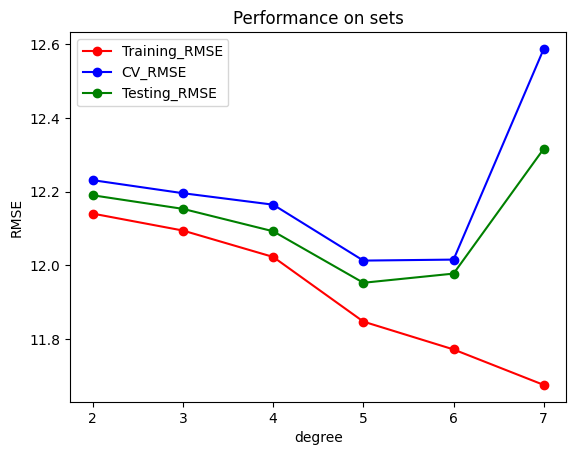


Best test score hyperparameters

RMSE:11.953183294476409
optimal_degree:5



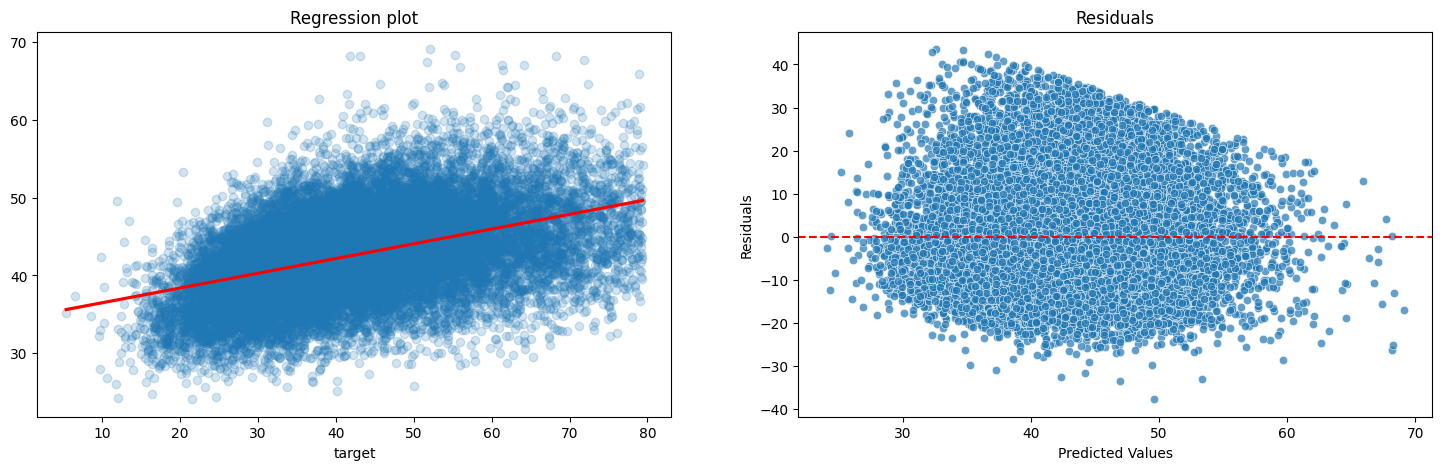

In [56]:
res_linear = find_best_lin_model(X_train_lin, y_train_lin, X_cv_lin, y_cv_lin, X_test_lin, y_test_lin, model='Linear', poly_degree=range(2, 8))

This is interesting, the best test score was when the model had a 6 order degree polynomial but you can see that the difference between training and testing is bigger, which is a sign of overfitting, and this is when the Ridge Regression comes to play, the lambda could help us reduce the overfitting so we can try the highest order polynomials from this model, like 5 and see how they perform depending on the value of lambda and compare, if the test score is less than the linear regression score, then Ridge regression may be a better choice.

Performance on the Ridge model



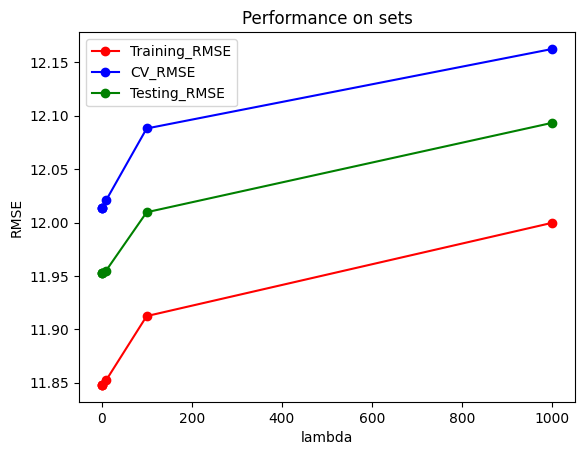


Best test score hyperparameters

RMSE:11.952909853513448
lambda:1



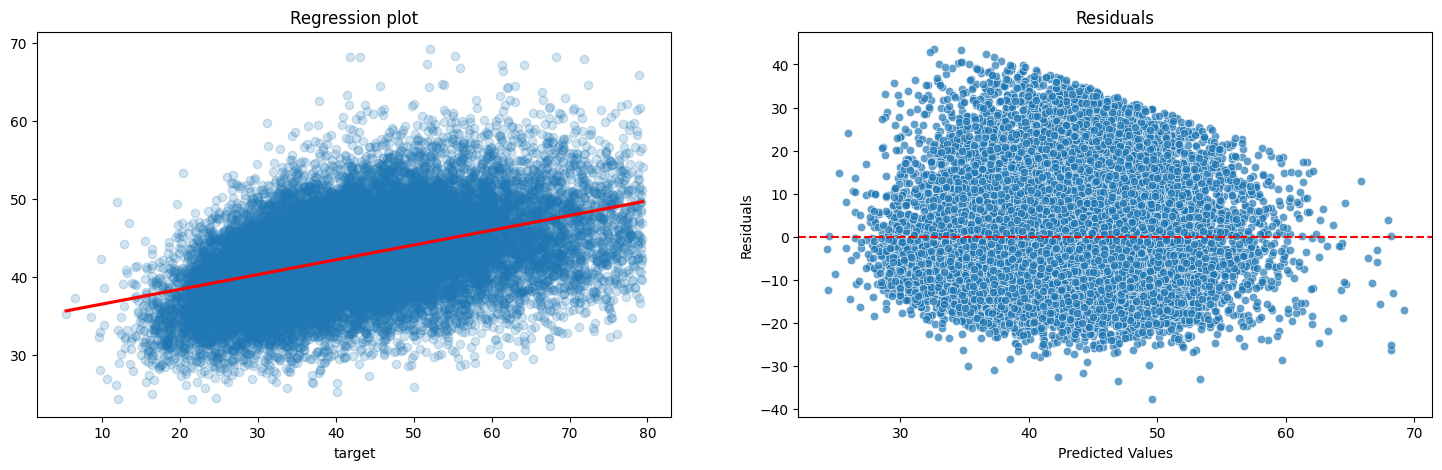

In [57]:
res_ridge_deg5 = res_linear = find_best_lin_model(X_train_lin, y_train_lin, X_cv_lin, y_cv_lin, X_test_lin, y_test_lin, model='Ridge', poly_degree=5)

It turns out that ridge regression didn't help that much and the regularization also didn't help on the testing performance, so we have to decide which one is the best model from all these linear ones. I will say that 4 could be a good choice because at degree 5, the difference between training and cv, testing results is way considerably higher, so just to avoid as much as we can overfitting, let's pick a 4th degree polynomial Linear Regression as our best Linear model for this data.

In [58]:
y_test_linear, y_pred_linear, residuals_linear, train_rmse_linear,\
cv_rmse_linear, test_rmse_linear = train_linear_model(X_train_lin, y_train_lin, X_cv_lin, y_cv_lin, X_test_lin, y_test_lin, model='linear', \
                                                                    poly=True, lambda_=0, poly_features=5)

--------------------- Model with 5 polynomial order ----------------------

--------------------------- Linear Model -------------------------------

Train_results

r2: 0.2

MAE: 9.47

RMSE: 11.85

P90: 18.89


CV results

r2: 0.18

MAE: 9.58

RMSE: 12.01

P90: 19.35


test results

r2: 0.19

MAE: 9.55

RMSE: 11.95

P90: 19.2


The best result training the data on a linear model was an MAE of 9.52, but for a non-linear model the results should be better.

Now that there is a function for everything, we can just pick our continuous and categorical features and convert them, then train it with NN or ensemble models that tend to do better than just linear models.

In [53]:
continuous_features = [ 'total_items', 'subtotal',
                        'num_distinct_items', 'min_item_price', 'max_item_price',
                        'total_onshift_dashers', 'total_busy_dashers',
                        'total_outstanding_orders', 'estimated_order_place_duration',
                        'estimated_store_to_consumer_driving_duration', 'available_dashers',
                        'utilized_dashers', 'orders_to_available_dashers', 'avg_price_item',
                        'item_variety', 'total_non_taken_orders']

categorical_features = ['store_primary_category_counts', 'market_id_1.0', 'market_id_2.0',
       'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0',
       'order_protocol_1.0', 'order_protocol_2.0', 'order_protocol_3.0',
       'order_protocol_4.0', 'order_protocol_5.0', 'order_protocol_6.0',
       'order_protocol_7.0']


X_train_nl, y_train_nl, X_cv_nl, y_cv_nl, X_test_nl, y_test_nl = transform_features(df_new, 'target', 'standard', continuous=continuous_features, categorical=categorical_features)

Now let's create a function to train the model you want. What I would do is use Grid Search to try to find the best parameters for the model I want, that in this case it would be XGBoost.

In [54]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


def train_nonlinear(model, data:pd.DataFrame, target:str, continuous_cols, categorical_cols, grid_search=True, params:dict=None):

    params_xgboost = {
                        'learning_rate': [0.05, 0.1, 0.5],
                        'n_estimators': [100, 200, 500],
                        'max_depth': [2, 4, 6]
    }


    if model.lower() == 'xgboost':
        regressor = XGBRegressor()
    else:
        return 'The model should be one of these (XGBoost, RF)'


    if grid_search:

        params = params_xgboost

        X = data[continuous_cols + categorical_cols]
        y = data[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        standard = StandardScaler()
        X_train = standard.fit_transform(X_train)
        X_test = standard.transform(X_test)

        grid = GridSearchCV(regressor, param_grid=params, cv=5, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
        grid.fit(X_train, y_train)

        best_model = grid.best_estimator_
        results = pd.DataFrame(grid.cv_results_)
        feature_importance = pd.DataFrame(grid.best_estimator_.feature_importances_, index=X.columns, columns=['Values'])
        feature_importance = feature_importance.sort_values(by='Values', ascending=False).iloc[0:10, :]

        test_pred = grid.best_estimator_.predict(X_test)
        residuals = y_test - test_pred

        print(f'Best params: {grid.best_params_}\n')

        print('\nResults on training set\n')
        training_score = abs(results['mean_train_score'].mean())
        print(f'MAE: {training_score}\n')

        print('\nResults on Cross-Validation:\n')
        val_score = abs(results['mean_test_score'].mean())
        print(f'MAE: {val_score}\n')

        print('\nResults on testing data:\n')
        testing_score = mean_absolute_error(y_test, test_pred)
        r2_testing = r2_score(y_test, test_pred)
        print(f'R2: {r2_testing}\n')
        print(f'MAE: {testing_score}\n')

        print(f'\nFeature importance\n')
        sns.barplot(x=feature_importance['Values'], y=feature_importance.index)
        print()

        return grid, training_score, val_score, testing_score, y_test, test_pred, residuals

    else:

        X_train_nl, y_train_nl, X_cv_nl, y_cv_nl, X_test_nl, y_test_nl = \
            transform_features(data=data, target=target, scaler_choosen='standard', continuous=continuous_cols, categorical=categorical_cols)

        regressor = XGBRegressor(**params)   # This unpacks the dictionary

        regressor.fit(X_train_nl, y_train_nl)

        train_pred = regressor.predict(X_train_nl)
        cv_pred = regressor.predict(X_cv_nl)
        test_pred = regressor.predict(X_test_nl)

        train_residuals = y_train_nl - train_pred
        cv_residuals = y_cv_nl - cv_pred
        test_residuals = y_test_nl - test_pred

        print('Train_results\n')
        train_r2 = r2_score(y_train_nl, train_pred)
        train_mae = mean_absolute_error(y_train_nl, train_pred)
        train_rmse = root_mean_squared_error(y_train_nl, train_pred)
        train_p90 = np.percentile(abs(train_residuals), 90)
        print(f'r2: {round(train_r2, 2)}\n')
        print(f'MAE: {round(train_mae, 2)}\n')
        print(f'RMSE: {round(train_rmse, 2)}\n')
        print(f'P90: {round(train_p90, 2)}\n\n')

        print('CV results\n')
        cv_r2 = r2_score(y_cv_nl, cv_pred)
        cv_mae = mean_absolute_error(y_cv_nl, cv_pred)
        cv_rmse = root_mean_squared_error(y_cv_nl, cv_pred)
        cv_p90 = np.percentile(abs(cv_residuals), 90)
        print(f'r2: {round(cv_r2, 2)}\n')
        print(f'MAE: {round(cv_mae, 2)}\n')
        print(f'RMSE: {round(cv_rmse, 2)}\n')
        print(f'P90: {round(cv_p90, 2)}\n\n')

        print('test results\n')
        test_r2 = r2_score(y_test_nl, test_pred)
        test_mae = mean_absolute_error(y_test_nl, test_pred)
        test_rmse = root_mean_squared_error(y_test_nl, test_pred)
        test_p90 = np.percentile(abs(test_residuals), 90)
        print(f'r2: {round(test_r2, 2)}\n')
        print(f'MAE: {round(test_mae, 2)}\n')
        print(f'RMSE: {round(test_rmse, 2)}\n')
        print(f'P90: {round(test_p90, 2)}')

        return regressor, train_rmse, cv_rmse, test_rmse, y_test_nl, test_pred, test_residuals

I would like to find the best model and I will try to do it without Grid Search first, for that I am going to change the hyperparameters and see how the model performs with each hyperparameter singularly, then I will just merge together the best ones in one model.

In [55]:
def compare_nl_models(param:list, param_name:str):
    training_scores = []
    val_scores = []
    testing_scores = []

    with contextlib.redirect_stdout(io.StringIO()):

        for depth in param:
            xgboost_model, train_RMSE, val_RMSE, test_RMSE, y_test_nl, xgboost_test_pred, xgboost_residuals = \
                train_nonlinear(model='XGBoost', data=df_new, target='target', continuous_cols=continuous_features, categorical_cols=categorical_features, \
                    grid_search=False, params={param_name:depth, 'random_state':42})

            training_scores.append(train_RMSE)
            val_scores.append(val_RMSE)
            testing_scores.append(test_RMSE)

    best_score = min(val_scores)
    index_bs = val_scores.index(best_score)

    plot_comparison(param, training_scores, val_scores, x_axis=param_name, scoring='RMSE')

    print()
    print(f'Best param for {param_name}: {param[index_bs]}')

    return param[index_bs]

Let's see what happens if I try a grid search.

Best params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}


Results on training set

MAE: 8.273019149921097


Results on Cross-Validation:

MAE: 9.13841026210812


Results on testing data:

R2: 0.2719335372878533

MAE: 8.938194804389841


Feature importance





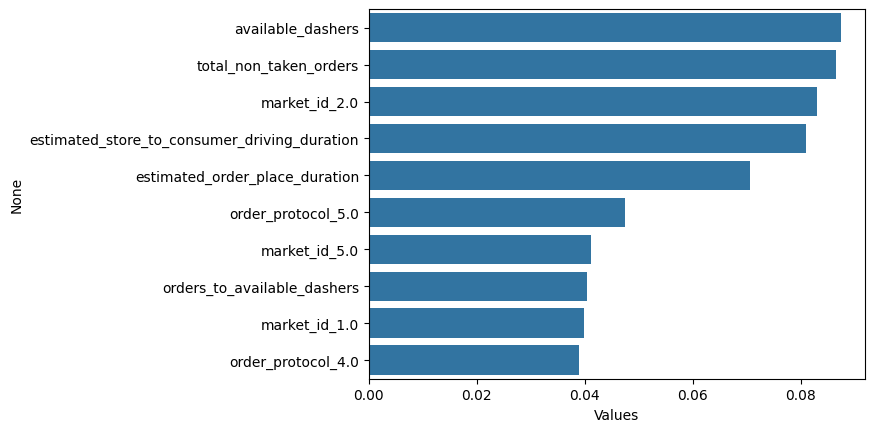

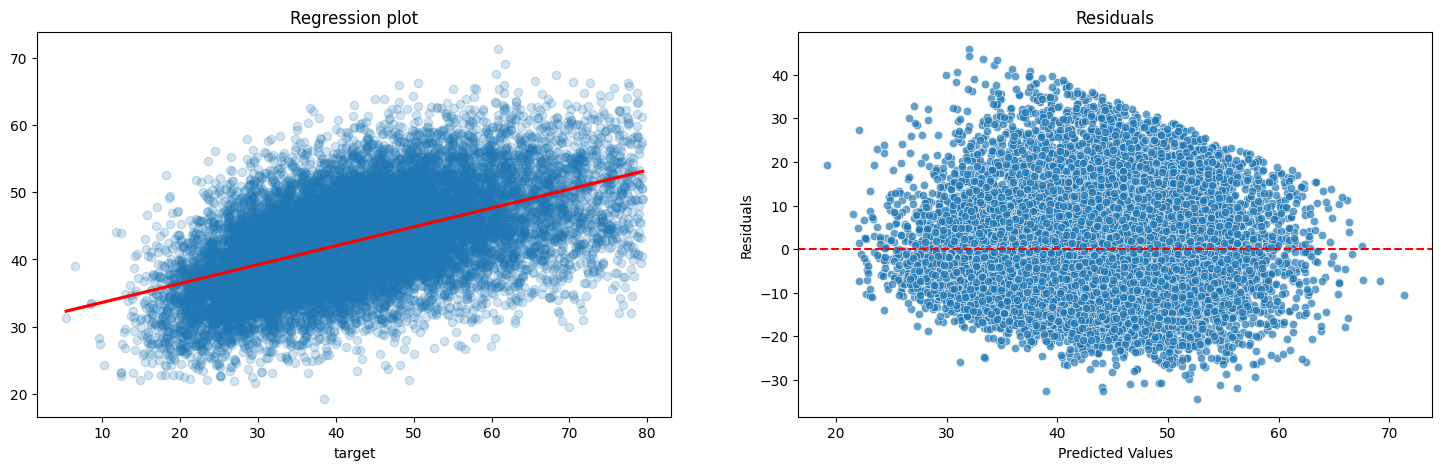

In [64]:
grid, training_score, val_score, testing_score, y_test, test_pred, residuals = \
    train_nonlinear(model='xgboost', data=df_new, target='target', continuous_cols=continuous_features, \
                    categorical_cols=categorical_features, grid_search=True)
print()
plot_results(y_test, test_pred, residuals)

XGBoost had a pretty similar performance than the Linear Regression, this teaches us that is not true that non linear models will always outperform the linear ones. Now let's try a neural network but what I would like to do further is to investigate those cases in which the error the model is making is too big.

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import linear, relu
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf


def train_nn(data, target, continuous_cols, categorical_cols, lr, epochs):

    # For reproducibility
    tf.random.set_seed(1000)

    X_train_nl, y_train_nl, X_cv_nl, y_cv_nl, X_test_nl, y_test_nl = \
                transform_features(data=data, target=target, scaler_choosen='standard', continuous=continuous_cols, categorical=categorical_cols)

    # Correctly calculate input size based on the training data shape
    input_size = X_train_nl.shape[1]

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        min_lr=0.0001)

    NN = Sequential([
                    tf.keras.Input(shape=(input_size,)),
                    tf.keras.layers.Dense(32, activation='relu'),
                    tf.keras.layers.Dense(16, activation='relu'),
                    tf.keras.layers.Dense(8, activation='relu'),
                    tf.keras.layers.Dense(units=1, activation='linear')
                    ]
    )



    NN.compile(
                optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                loss = tf.keras.losses.MeanSquaredError(),
                metrics = ['mean_absolute_error']
    )

    NN.fit(X_train_nl, y_train_nl, epochs=epochs, callbacks=[reduce_lr])

    train_pred_NN = NN.predict(X_train_nl)
    cv_pred_NN = NN.predict(X_cv_nl)
    test_pred_NN = NN.predict(X_test_nl)
    residuals_NN = y_test_nl - test_pred_NN.flatten()

    print(f'Training error {mean_absolute_error(y_train_nl, train_pred_NN)}')
    print(f'Validation error {mean_absolute_error(y_cv_nl, cv_pred_NN)}\n')
    print(f'Testing error {mean_absolute_error(y_test_nl, test_pred_NN)}\n')

    return y_test_nl, test_pred_NN, residuals_NN



In [68]:
y_test_nl, test_pred_NN, residuals_NN = train_nn(df_new, 'target', continuous_features, categorical_features, lr=0.01, epochs=50)

Epoch 1/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 2s 959us/step - loss: 1319.9692 - mean_absolute_error: 21.5593 - learning_rate: 0.0100
Epoch 2/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - loss: 182.8430 - mean_absolute_error: 10.5844 - learning_rate: 0.0100
Epoch 3/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - loss: 154.0587 - mean_absolute_error: 9.8677 - learning_rate: 0.0100
Epoch 4/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - loss: 148.5983 - mean_absolute_error: 9.7183 - learning_rate: 0.0100
Epoch 5/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - loss: 147.9023 - mean_absolute_error: 9.6953 - learning_rate: 0.0100
Epoch 6/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - loss: 148.6550 - mean_absolute_error: 9.7424 - learning_rate: 0.0100
Epoch 7/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - loss: 147.5298 - mean_absolute_error: 9.7023 - learning_rate: 0.0100
Epoch 8/50
1264/1264 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - loss: 145.9834 - mean_absolute_error: 9.6557 - lea

The neural network makes a very similar mistake than the XGBoost model, this is telling us that until this point, that is what the model is capable of doing, we already clean the data, drop outliers and added new features, but if we want a better result we need even more feature engineering, so let's try to create new features from the existing ones and try the XGBoost model.

Let's keep up adding some features like:

- Add Holidays
- Dashers by orders
- Volatilility of prices in the order
- Delivery difficulty
- Time taken by each restaurant using its id
- Delivery Speed

In [56]:
import holidays

# Time and days

holidays = holidays.US()
df_new['is_holiday'] = df_new['created_at'].dt.date.astype(str).isin(holidays).astype(int)

# Price related

df_new['price_range'] = df_new['max_item_price'] - df_new['min_item_price']
df_new['price_volatility'] = (df_new['price_range'] / df_new['avg_price_item']).replace(np.inf, 0)

# Orders

df_new['delivery_difficulty'] = (df_new['orders_to_available_dashers'] * df_new['estimated_store_to_consumer_driving_duration']).replace(np.inf, 0)

# Restaurant

grouped_df_place_duration = df_new.groupby('store_id')['estimated_order_place_duration'].mean().reset_index()
grouped_df_store_to_consumer = df_new.groupby('store_id')['estimated_store_to_consumer_driving_duration'].mean().reset_index()

store_place_duration = {store: time for store, time, in zip(grouped_df_place_duration['store_id'], grouped_df_place_duration['estimated_order_place_duration'])}
store_to_consumer = {store: time for store, time, in zip(grouped_df_store_to_consumer['store_id'], grouped_df_store_to_consumer['estimated_store_to_consumer_driving_duration'])}

df_new['historical_avg_store_place_duration'] = df_new['store_id'].map(store_place_duration)
df_new['historical_avg_store_to_consumer_duration'] = df_new['store_id'].map(store_to_consumer)

# Speed of delivery

df_new['Delivery_Speed'] = ((df_new['historical_avg_store_to_consumer_duration'] + df_new['estimated_store_to_consumer_driving_duration']) / 2).replace(np.inf, 0)

Let's clean a little bit more the dataset.

In [57]:
df_new = df_new[df_new['price_range'] >= 0]

In [58]:
new_continuous_features = ['price_range', 'price_volatility', 'delivery_difficulty',
                       'historical_avg_store_place_duration', 'historical_avg_store_to_consumer_duration',
                       'Delivery_Speed']

new_categorical_features = ['is_holiday']

continuous_features = continuous_features + new_continuous_features
categorical_features = categorical_features + new_categorical_features

Before training the model, I would like to see the outliers for each column and delete those rows that doesn't make sense, so let's calculate each IQR and total outliers for each column and see the severity of the outliers and what is causing them to be that way.

In [59]:
for col in new_continuous_features:
    Lower_lim, Upper_lim = calculate_IQR_limits(df_new[col])
    print(f'Outliers for {col}\n\nRanges: Min: {round(Lower_lim, 2), round(Upper_lim, 2)} Outliers: {df_new[(df_new[col] < Lower_lim) | (df_new[col] > Upper_lim)][col].shape[0]}\n\n')

Outliers for price_range

Ranges: Min: (np.float64(-9.9), np.float64(16.5)) Outliers: 234


Outliers for price_volatility

Ranges: Min: (np.float64(-1.4), np.float64(2.33)) Outliers: 625


Outliers for delivery_difficulty

Ranges: Min: (np.float64(-53.98), np.float64(89.97)) Outliers: 6431


Outliers for historical_avg_store_place_duration

Ranges: Min: (np.float64(-0.69), np.float64(12.31)) Outliers: 0


Outliers for historical_avg_store_to_consumer_duration

Ranges: Min: (np.float64(5.18), np.float64(12.84)) Outliers: 1910


Outliers for Delivery_Speed

Ranges: Min: (np.float64(2.53), np.float64(15.4)) Outliers: 219




Let's go column by column and see the origin of all the outliers.

First of all, it makes no sense a negative price range, max_item_price should always be higher or the same than the lower so let's drop those columns.

In [60]:
df_new = df_new[df_new['min_item_price'] > 0]

Best params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}


Results on training set

MAE: 8.174148665682516


Results on Cross-Validation:

MAE: 9.107362950765594


Results on testing data:

R2: 0.2968767823200372

MAE: 8.74193786655894


Feature importance




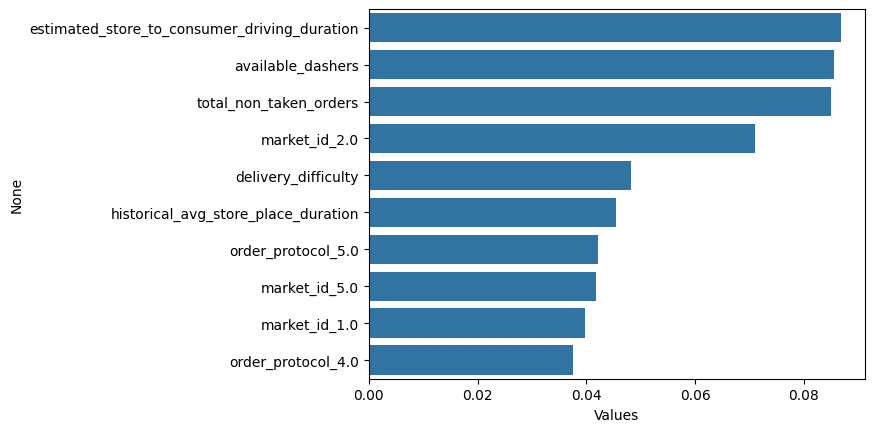

In [61]:
grid_fin, training_score_fin, val_score_fin, testing_score_fin, y_test_fin, test_pred_fin, residuals_fin = \
    train_nonlinear(model='xgboost', data=df_new, target='target', continuous_cols=continuous_features, \
                    categorical_cols=categorical_features, grid_search=True)

Let's check where is the model making the most mistakes.

In [62]:
pred_vs_act_df = create_prediction_results(y_test_fin, test_pred_fin)
pred_vs_act_df.head()

Actual       Pred       Diff   Abs_Diff
46843  49.966667  45.501659  -4.465007   4.465007
53133  53.633333  56.538418   2.905084   2.905084
69920  27.100000  34.601208   7.501208   7.501208
47018  54.666667  46.500656  -8.166011   8.166011
77235  61.616667  39.016708 -22.599958  22.599958

Let's think about the business logic, every customer will hate more an underestimate than an overestimate, so underestimations is what we should avoid, let's see the ratio of underestimated against overestimated predictions.

In [63]:
pred_vs_act_df[pred_vs_act_df['Diff'] < 0].shape[0] / pred_vs_act_df[pred_vs_act_df['Diff'] > 0].shape[0]

0.7937682134050661

Here is the main issue of the model, 80% of the time it is underestimating, which is something we want to avoid.

Let's take a look to the biggest mistakes the model made and see what is causing that.

In [64]:
def get_mistake_indexes(data, lower_than, higher_than):
    indexes = data[(data['Diff'] > higher_than) | (data['Diff'] < lower_than)].index
    return indexes

In [65]:
top_mistakes_ind = get_mistake_indexes(pred_vs_act_df, -35, 35)

Perfect, now the way we can see why is it making the mistakes is choosing the most interpretable variables, and see if there are similarities.

In [66]:
feature_importance = pd.DataFrame(grid_fin.best_estimator_.feature_importances_, columns=['Feature_importance'])
feature_importance['Names'] = continuous_features + categorical_features

feature_importance = feature_importance.sort_values(by='Feature_importance', ascending=False)
feature_importance.head()

Feature_importance                                         Names
9             0.086854  estimated_store_to_consumer_driving_duration
10            0.085454                             available_dashers
15            0.084907                        total_non_taken_orders
24            0.070980                                 market_id_2.0
18            0.048157                           delivery_difficulty

In [67]:
for col in continuous_features:
    plt.figure() # Create a new figure for each plot
    sns.scatterplot(x=df_new[col], y=pred_vs_act_df['Diff'], alpha=0.4, label='All Mistakes')
    sns.scatterplot(x=df_new.loc[top_mistakes_ind, col], y=pred_vs_act_df.loc[top_mistakes_ind, 'Diff'], color='red', label='Top Mistakes')
    plt.xlabel(col)
    plt.ylabel('Pred_Diff')
    plt.title(f'Predicted vs Actual Difference on {col}')
    plt.legend()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

After watching all these charts, I noticed that some variables at some point are more used to make big mistakes, like:

- Subtotal between 0 and 20.
- Total onshift dashers between 40 and 50.
- Available dashers between 0 and 10.
- Orders to available dashers when there are close to 0 or 0.

So, to quantify the mistakes, let's calculate the mean residual by column, the way you do this is splitting each feature on ranges, and then you calculate the mean residual by each range.

In [68]:
def get_intervals(data, prediction_data, features):

    ranges = {}
    estimates = {col:[] for col in features}
    under_over_estimations = {col:[] for col in features}

    for col in features:
        ranges[col] = sorted(list(set(np.round(np.linspace(data[col].min(), data[col].max(), 5), 0).tolist())))

    for col in ranges:
        for i in range(1, len(ranges[col])):
            df_indexes = df_new[(data[col] >= ranges[col][i-1]) & (data[col] <= ranges[col][i])][col].index.tolist()
            intersection_indexes = list(set(df_indexes) & set(prediction_data.index.tolist()))
            bucket_mean = np.round(prediction_data.loc[intersection_indexes, 'Abs_Diff'].mean(), 2)
            if bucket_mean != np.nan:
                bucket_mean = float(bucket_mean)
            estimates[col].append(bucket_mean)

    return ranges, estimates

ranges1, estimates1 = get_intervals(df_new, pred_vs_act_df, continuous_features)

Let's calculate the mean for all the errors and then stablish a threshold.

In [69]:
values = [val for val_list in estimates1.values() for val in val_list]
threshold = np.round(np.nanmean(values), 2)
threshold

np.float64(8.75)

Think about this, the errors that are close to 8.75 will not cause a lot of damage, but the errors that are considerably higher, like 15 or more could potentially harm the model, so let's try and adjust the threshold, I will use 9.5 as the threshold.

In [70]:
def get_cols_with_big_errors(data, prediction_data, features):

    ranges_dict, estimates_dict = get_intervals(data, prediction_data, features)

    cols_with_problems = []

    for col in estimates_dict:
        if any(val > 9.5 for val in estimates_dict[col]):
            cols_with_problems.append(col)

    print('Columns with big errors:')

    for col in cols_with_problems:
        print('\n', col.upper(), '\n')
        print(ranges_dict[col])
        print(estimates_dict[col], '\n')

    return cols_with_problems

cols_with_errors = get_cols_with_big_errors(df_new, pred_vs_act_df, continuous_features)

Columns with big errors:

 ORDERS_TO_AVAILABLE_DASHERS 

[0.0, 17.0, 34.0, 51.0, 68.0]
[8.72, 9.17, 9.71, 8.12] 


 PRICE_VOLATILITY 

[0.0, 1.0, 3.0, 4.0, 5.0]
[8.72, 8.84, 8.45, 11.68] 


 DELIVERY_DIFFICULTY 

[0.0, 281.0, 562.0, 843.0, 1124.0]
[8.74, 8.99, 9.21, 11.07] 


 HISTORICAL_AVG_STORE_TO_CONSUMER_DURATION 

[1.0, 6.0, 10.0, 15.0, 20.0]
[9.96, 8.71, 8.66, 8.53] 



So there we have the columns and the specific buckets that make the biggest mistakes, for example price range has a little high error between 15 and 20, price volatility usually underestimates between 3 and 4 and overestimates between 4 and 5 and so on. The way we target this errors is creating new features for prices, delivery difficulty, delivery speed and historical average, we will also fit a model with the residuals using these high error variables.

Let's understand each result:

Orders that have a wide price range could take longer, this could mean they have complex menus

The model fails when the delivery difficulty is too big, this scenarios usually occur when there are too much orders for a few dashers, which suggests that the model is probably not reacting fast enough to dynamic driver availability. It also fails on historic averages meaning that it is relying too much on historical averages rather than adapting to current conditions.

In general terms, the model is static but the problem is dynamic.

So to correct these, each of this features should need a little bit more of feature engineering:

For price features, interaction with time of the day should be added, like if it is a peak hour and also the menu complexity, we could do this by creating a categorical variable that measures the menu complexity by restaurant. So let's start by fixing the feature's disstribution, I would like to change as much as I can the distribution for not having those few values that could potentially lead to errors.

Esto es lo que vas a hacer mañana, primero vas a tomar la columna de price range y sacarel minimo y maximo y dividirla en 3 partes iguales, asi como hicimos arriba solo que arriba era con 5 partes iguales, esto lo puedes hacer con linspace de numpy, cuando termines eso vas a categorizar el rango de precio de el restaurant, si es alto, bajo o medio, despues a eso le vas a agregar el tipo de cocina, osea vas a concatenar el rango de precio y el tipo de comida que venden como una categorizacion. Eso es lo primero, luego vuelve a chatgpt para seguir con el feature engineering.

<Axes: xlabel='price_volatility', ylabel='Count'>

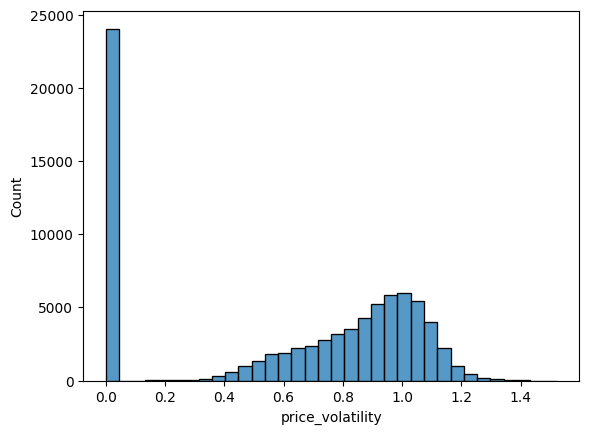

In [71]:
from scipy.stats import boxcox

sns.histplot(df_new['price_volatility']**0.25)

In [72]:
df_new['price_volatility_norm'] = df_new['price_volatility'] ** 0.25

Fine, now we should target the price features using the order complexity for each restaurant, the order complexity will be calculated by using the price range of each individual order, then we will add the type of restaurant and hot encode it, for example, we will have examples like Sushi_Low, which means is a Sushi order with Low complexity.

In [73]:
def get_complexity(row):
    if row < price_range_buckets[1]:
        return 'Low'
    elif row > price_range_buckets[2]:
        return 'Medium'
    else:
        return 'High'

price_range_buckets = np.linspace(df_new['price_range'].min(), df_new['price_range'].max(), 4).tolist()

df_new['order_complexity'] = df_new['price_range'].apply(get_complexity)
df_new['order_complexity'] = df_new['order_complexity'].astype(str) + '_' + df_new['store_primary_category']

This is a categorical column so we need to one hot encode it.

In [74]:
print(f'Before one hot encode: {df_new.shape[1]} columns')

df_new = pd.get_dummies(df_new, columns=['order_complexity'], prefix='ord_complex', dtype=int)

print(f'After one hot encode: {df_new.shape[1]} columns')

Before one hot encode: 50 columns
After one hot encode: 140 columns


Now let's add a dynamic feature, many times the orders could take longer if it is a peak hour, so let's get the peak hour and then multiply it by the price volatility.

In [75]:
peak_hours = df_new.groupby('hour_of_day')['total_outstanding_orders'].sum().reset_index().sort_values(by='total_outstanding_orders', ascending=False)
peak_hours = peak_hours['hour_of_day'].head(6).to_list()

df_new['is_peak_hour'] = (df_new['hour_of_day'].isin(peak_hours)).astype(int)

df_new['price_volatility_x_peak_hour'] = df_new['price_volatility'] * df_new['is_peak_hour']

We can also add the price volatitlity times the number of distinct items.

In [76]:
df_new['price_volatility_x_items'] = df_new['price_volatility'] * df_new['num_distinct_items']

We can also add the mean of each cuisine's price volatility and assign it.

In [77]:
volat_per_cuisine = df_new.groupby('store_primary_category')['price_volatility'].mean()

df_new['volat_mean_per_cuisine'] = df_new['store_primary_category'].map(volat_per_cuisine)

Another feature we could add is the relative price range and the relative price volatility, to calculate this we need the average price range and the average price volatility by each store, then we will divide the mean by the actual value and if it is higher than one it means that it has a high volatility.

In [78]:
mean_price_range_per_store = df_new.groupby('store_id')['price_range'].mean()
mean_price_volat_per_store = df_new.groupby('store_id')['price_volatility'].mean()

df_new['relative_price_range'] = df_new['store_id'].map(mean_price_range_per_store)
df_new['relative_price_volatility'] = df_new['store_id'].map(mean_price_volat_per_store)

Perfect, now that we created new features targetting the errors the model made with price features, let's target the delivery diffulty, orders to available dashers and the historical average store to consumer duration.

In [79]:
df_new = df_new.drop('index', axis=1)

In [80]:
# Let's start by converting the delivery difficulty and the orders to available dashers
# feature to avoid skewed data

df_new['log_delivery_difficulty'] = np.log1p(df_new['delivery_difficulty'])
df_new['log_orders_to_available_dashers'] = np.log1p(df_new['orders_to_available_dashers'])

In [81]:
# Now let's create a binary column where we flag if the orders to available dashers is
# too big, for this, our threshold will be, if there are more than 3 orders per dasher,
# it is considered a high supply demand ratio because 3 orders by a single dasher is too much

df_new['high_stress_flag'] = (df_new['orders_to_available_dashers'] > 3).astype(int)

We have a very usefull columns that is the market id column, with that we can group the data and also include the time of the day, so let's add that region stats.

We can also merge peak hours and distance with the dashers availability

In [82]:
df_new['stress_x_peak'] = df_new['orders_to_available_dashers'] * df_new['is_peak_hour']
df_new['stress_x_distance'] = df_new['orders_to_available_dashers'] * df_new['estimated_store_to_consumer_driving_duration']

Let's take the log and the squared transformation of the distance to get more information considering we are using a non linear model.

In [83]:
df_new['log_distance'] = np.log1p(df_new['estimated_store_to_consumer_driving_duration'])
df_new['squared_distance'] = df_new['estimated_store_to_consumer_driving_duration'] ** 2

Let's add also the hour factor to the delivery difficulty, this means some zones will be harder to reach on those peak hours for the dashers.

In [84]:
df_new['delivery_difficulty_x_rush'] = df_new['delivery_difficulty'] * df_new['is_peak_hour']

Let's calculate the relative store_to_consumer_duration.

In [85]:
df_new['rel_store_duration'] = (df_new['estimated_store_to_consumer_driving_duration'] / df_new['historical_avg_store_to_consumer_duration']).replace(np.inf, 0)

Perfect, now it's time to test the model again, but considering the dataset has grown to much in terms of dimensions, testing the neural networks may also be a good idea.

In [86]:
continuous_features = ['total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'estimated_order_place_duration',
       'estimated_store_to_consumer_driving_duration', 'hour_of_day',
       'day_of_week', 'weekend', 'available_dashers', 'utilized_dashers',
       'total_non_taken_orders', 'orders_to_available_dashers',
       'avg_price_item', 'item_variety', 'store_primary_category_counts',
       'price_range', 'price_volatility', 'delivery_difficulty',
       'historical_avg_store_place_duration',
       'historical_avg_store_to_consumer_duration', 'Delivery_Speed',
       'price_volatility_norm', 'price_volatility_x_peak_hour', 'price_volatility_x_items',
       'volat_mean_per_cuisine', 'relative_price_range',
       'relative_price_volatility', 'log_delivery_difficulty',
       'log_orders_to_available_dashers', 'stress_x_peak', 'stress_x_distance', 'log_distance',
       'squared_distance', 'delivery_difficulty_x_rush', 'rel_store_duration']


categorical_features = ['market_id_1.0', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0',
       'market_id_5.0', 'market_id_6.0', 'order_protocol_1.0',
       'order_protocol_2.0', 'order_protocol_3.0', 'order_protocol_4.0',
       'order_protocol_5.0', 'order_protocol_6.0', 'order_protocol_7.0',
       'is_holiday', 'ord_complex_High_Other',
       'ord_complex_High_Unknown', 'ord_complex_High_alcohol',
       'ord_complex_High_american', 'ord_complex_High_asian',
       'ord_complex_High_barbecue', 'ord_complex_High_breakfast',
       'ord_complex_High_burger', 'ord_complex_High_cafe',
       'ord_complex_High_catering', 'ord_complex_High_chinese',
       'ord_complex_High_dessert', 'ord_complex_High_fast',
       'ord_complex_High_greek', 'ord_complex_High_hawaiian',
       'ord_complex_High_indian', 'ord_complex_High_italian',
       'ord_complex_High_japanese', 'ord_complex_High_korean',
       'ord_complex_High_mediterranean', 'ord_complex_High_mexican',
       'ord_complex_High_middle-eastern', 'ord_complex_High_other',
       'ord_complex_High_pizza', 'ord_complex_High_salad',
       'ord_complex_High_sandwich', 'ord_complex_High_seafood',
       'ord_complex_High_smoothie', 'ord_complex_High_sushi',
       'ord_complex_High_thai', 'ord_complex_High_vietnamese',
       'ord_complex_Low_Other', 'ord_complex_Low_Unknown', 'ord_complex_Low_alcohol',
       'ord_complex_Low_american', 'ord_complex_Low_asian',
       'ord_complex_Low_barbecue', 'ord_complex_Low_breakfast',
       'ord_complex_Low_burger', 'ord_complex_Low_cafe',
       'ord_complex_Low_catering', 'ord_complex_Low_chinese',
       'ord_complex_Low_dessert', 'ord_complex_Low_fast',
       'ord_complex_Low_greek', 'ord_complex_Low_hawaiian',
       'ord_complex_Low_indian', 'ord_complex_Low_italian',
       'ord_complex_Low_japanese', 'ord_complex_Low_korean',
       'ord_complex_Low_mediterranean', 'ord_complex_Low_mexican',
       'ord_complex_Low_middle-eastern', 'ord_complex_Low_other',
       'ord_complex_Low_pizza', 'ord_complex_Low_salad',
       'ord_complex_Low_sandwich', 'ord_complex_Low_seafood',
       'ord_complex_Low_smoothie', 'ord_complex_Low_sushi',
       'ord_complex_Low_thai', 'ord_complex_Low_vietnamese',
       'ord_complex_Medium_Other', 'ord_complex_Medium_Unknown',
       'ord_complex_Medium_alcohol', 'ord_complex_Medium_american',
       'ord_complex_Medium_asian', 'ord_complex_Medium_barbecue',
       'ord_complex_Medium_breakfast', 'ord_complex_Medium_burger',
       'ord_complex_Medium_catering', 'ord_complex_Medium_chinese',
       'ord_complex_Medium_dessert', 'ord_complex_Medium_fast',
       'ord_complex_Medium_greek', 'ord_complex_Medium_hawaiian',
       'ord_complex_Medium_indian', 'ord_complex_Medium_italian',
       'ord_complex_Medium_japanese', 'ord_complex_Medium_korean',
       'ord_complex_Medium_mediterranean', 'ord_complex_Medium_mexican',
       'ord_complex_Medium_middle-eastern', 'ord_complex_Medium_other',
       'ord_complex_Medium_pizza', 'ord_complex_Medium_salad',
       'ord_complex_Medium_sandwich', 'ord_complex_Medium_seafood',
       'ord_complex_Medium_sushi', 'ord_complex_Medium_thai',
       'ord_complex_Medium_vietnamese', 'is_peak_hour', 'high_stress_flag']

Best params: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 500}


Results on training set

MAE: 7.906953051452043


Results on Cross-Validation:

MAE: 8.865428769901651


Results on testing data:

R2: 0.3364954594326349

MAE: 8.476581303640117


Feature importance




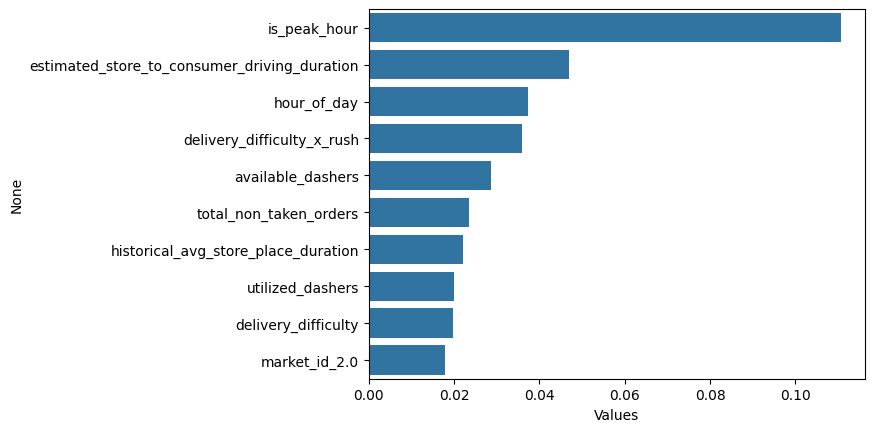

In [87]:
grid_fin2, training_score_fin2, val_score_fin2, testing_score_fin2, y_test_fin2, test_pred_fin2, residuals_fin2 = \
    train_nonlinear(model='xgboost', data=df_new, target='target', continuous_cols=continuous_features, \
                    categorical_cols=categorical_features, grid_search=True)

At this point, I don't think the model could perform significantly better, so it's time to report results, so to do that I would like to give a range, instead of giving an estimate of 10 minutes for example I would prefer to give a range, for that range I would give a 10 minute variation. For example, if the model predicts the delivery time would be 10 minutes, I would say the delivery could take from 10 to 20 minutes. This because underestimation is terrible in this cases, customers will feel worse about that, so let's always give more room for more time.

One thing we can also do is identify which feature values produce out of range predictions and when we have one of those cases we can add an extra 5 minutes because the model would probably underestimate more than it uses to.

In [88]:
pred_vs_act_df2 = create_prediction_results(y_test_fin2, test_pred_fin2)
get_cols_with_big_errors(df_new, pred_vs_act_df2, continuous_features + categorical_features)

Columns with big errors:

 ORDERS_TO_AVAILABLE_DASHERS 

[0.0, 17.0, 34.0, 51.0, 68.0]
[8.45, 9.13, 9.65, 8.42] 


 PRICE_VOLATILITY 

[0.0, 1.0, 3.0, 4.0, 5.0]
[8.45, 8.58, 8.86, 9.89] 


 HISTORICAL_AVG_STORE_TO_CONSUMER_DURATION 

[1.0, 6.0, 10.0, 15.0, 20.0]
[9.72, 8.45, 8.36, 9.2] 


 DELIVERY_SPEED 

[1.0, 6.0, 10.0, 15.0, 20.0]
[8.94, 8.48, 8.32, 10.01] 


 PRICE_VOLATILITY_X_ITEMS 

[0.0, 6.0, 12.0, 18.0, 24.0]
[8.46, 8.86, 7.66, 10.64] 


 DELIVERY_DIFFICULTY_X_RUSH 

[0.0, 281.0, 562.0, 843.0, 1124.0]
[8.47, 8.78, 9.54, 8.54] 



['orders_to_available_dashers',
 'price_volatility',
 'historical_avg_store_to_consumer_duration',
 'Delivery_Speed',
 'price_volatility_x_items',
 'delivery_difficulty_x_rush']

In [89]:
cols_and_ranges = {'orders_to_available_dashers': [17, 51],
                   'price_volatility': [4, 5],
                   'historical_avg_store_to_consumer_duration': [1, 6],
                   'Delivery_Speed':[15, 20],
                   'price_volatility_x_items':[18, 24],
                   'delivery_difficulty_x_rush':[562, 843]}

In [93]:
def add_real_prediction(prediction, index):

    extra_time = 0

    for col, val_range in cols_and_ranges.items():

        pred_val = df_new.loc[index, col]
        if pred_val > min(val_range) and pred_val < max(val_range):
            extra_time = 15

    return f"{prediction:.0f} - {(prediction + 10 + extra_time):.0f} min"


Conviertelo en segundos

In [94]:
# Apply the function to each row by iterating through the index
pred_vs_act_df2['Predicted_Range'] = [add_real_prediction(row['Pred'], index) for index, row in pred_vs_act_df2.iterrows()]

display(pred_vs_act_df2.head())

Actual       Pred       Diff   Abs_Diff Predicted_Range
46843  49.966667  48.167652  -1.799015   1.799015     48 - 58 min
53133  53.633333  51.612038  -2.021296   2.021296     52 - 62 min
69920  27.100000  34.235783   7.135783   7.135783     34 - 44 min
47018  54.666667  48.021740  -6.644927   6.644927     48 - 58 min
77235  61.616667  38.405323 -23.211344  23.211344     38 - 48 min

So now we have our real and final model with his prediction, I will plot some metrics just to see how good it performs.

First, this is an histogram of the errors the model made

<Axes: xlabel='Diff', ylabel='Count'>

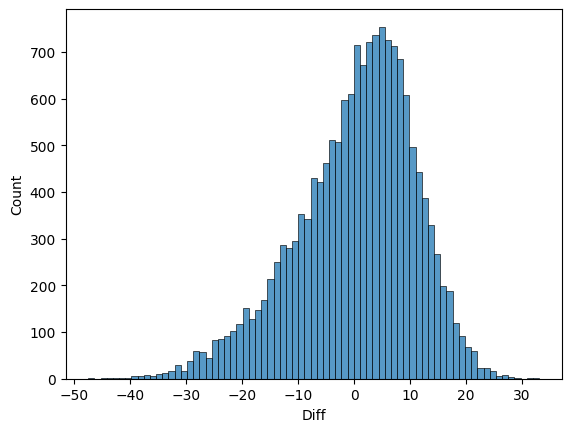

In [95]:
sns.histplot(pred_vs_act_df2['Diff'])

It is not a perfect normal distribution because the left side that represents the underestimation has a longer tail, and the top of the mountain or where it concentrates more is a little bit more than 0, but it's okay because given the features we have (they don't show a big correlation with the target value), it's okay to have a little Bias on our errors, that's why on the predicted value we add more minutes for the range, just to target those underestimations.

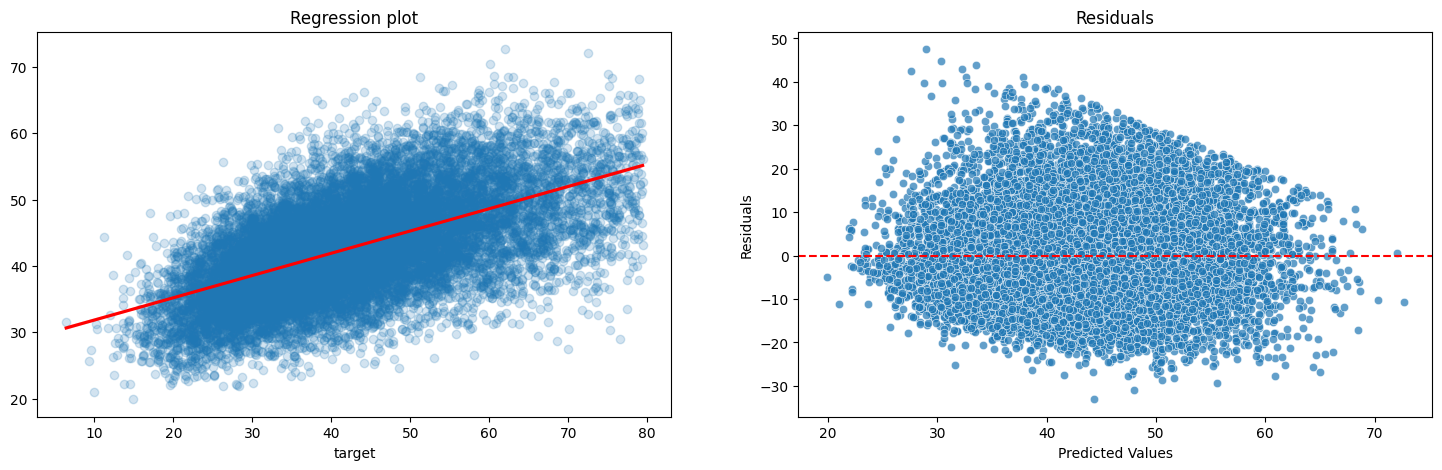

In [96]:
plot_results(y_test_fin2, test_pred_fin2, residuals_fin2)

On the left side you can see the line that fits the data and the right side shows how big are the errors depending on the values the model predicted, and you can see that the shorter the predicted value, the model usually tends to underestimate. Then you can see that overall, the underestimations may be higher than the overestimations.

<Axes: xlabel='Pred', ylabel='Count'>

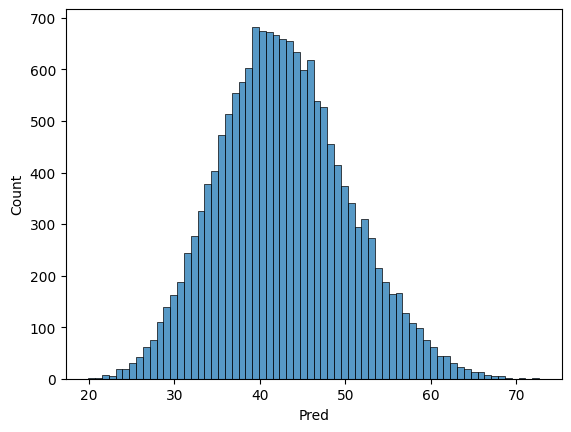

In [105]:
sns.histplot(pred_vs_act_df2['Pred'])

As you can see, the model predictions have a normal distribution and it usually predicts that the complete time from the order being sent to be delivered will be between 40 and 45 minutes. Let's see the real values and see if they also have this behavior.

<Axes: xlabel='Actual', ylabel='Count'>

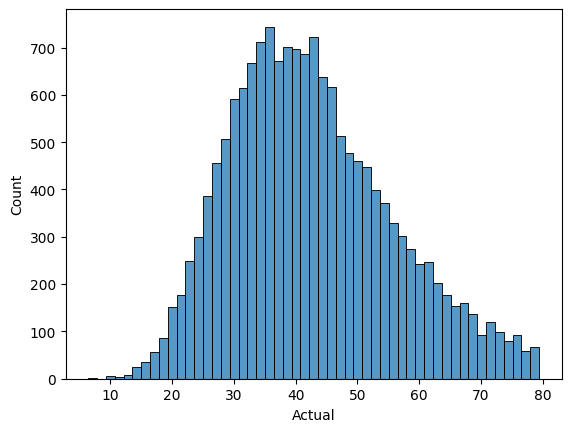

In [106]:
sns.histplot(pred_vs_act_df2['Actual'])

Here you can see the Bias toward the right, which means that there are a considerable amount of orders that take a little longer than usual, this could be causing those big underestimations.

<Axes: xlabel='Pred', ylabel='Count'>

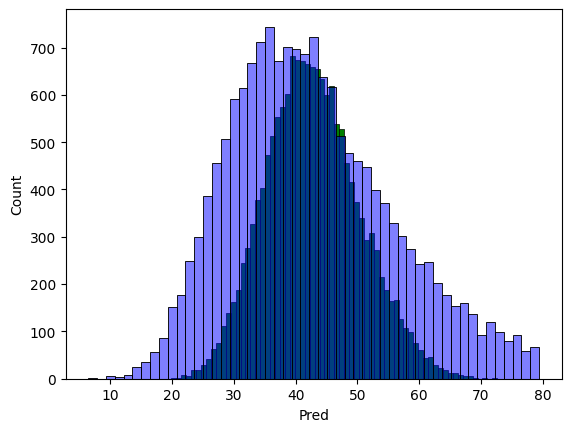

In [111]:
sns.histplot(pred_vs_act_df2['Pred'], alpha=1, color='g')
sns.histplot(pred_vs_act_df2['Actual'], alpha=0.5, color='b')

Here are the two of them plotted, the dark blue represents the predictions and the purple one the real values, it is not bad, but the model will perform greater if it goes a little bit more for longer predictions.